# First get the nonlinear examples on one plot

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import numpy as np
import os
import re
import pickle
os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/results/")

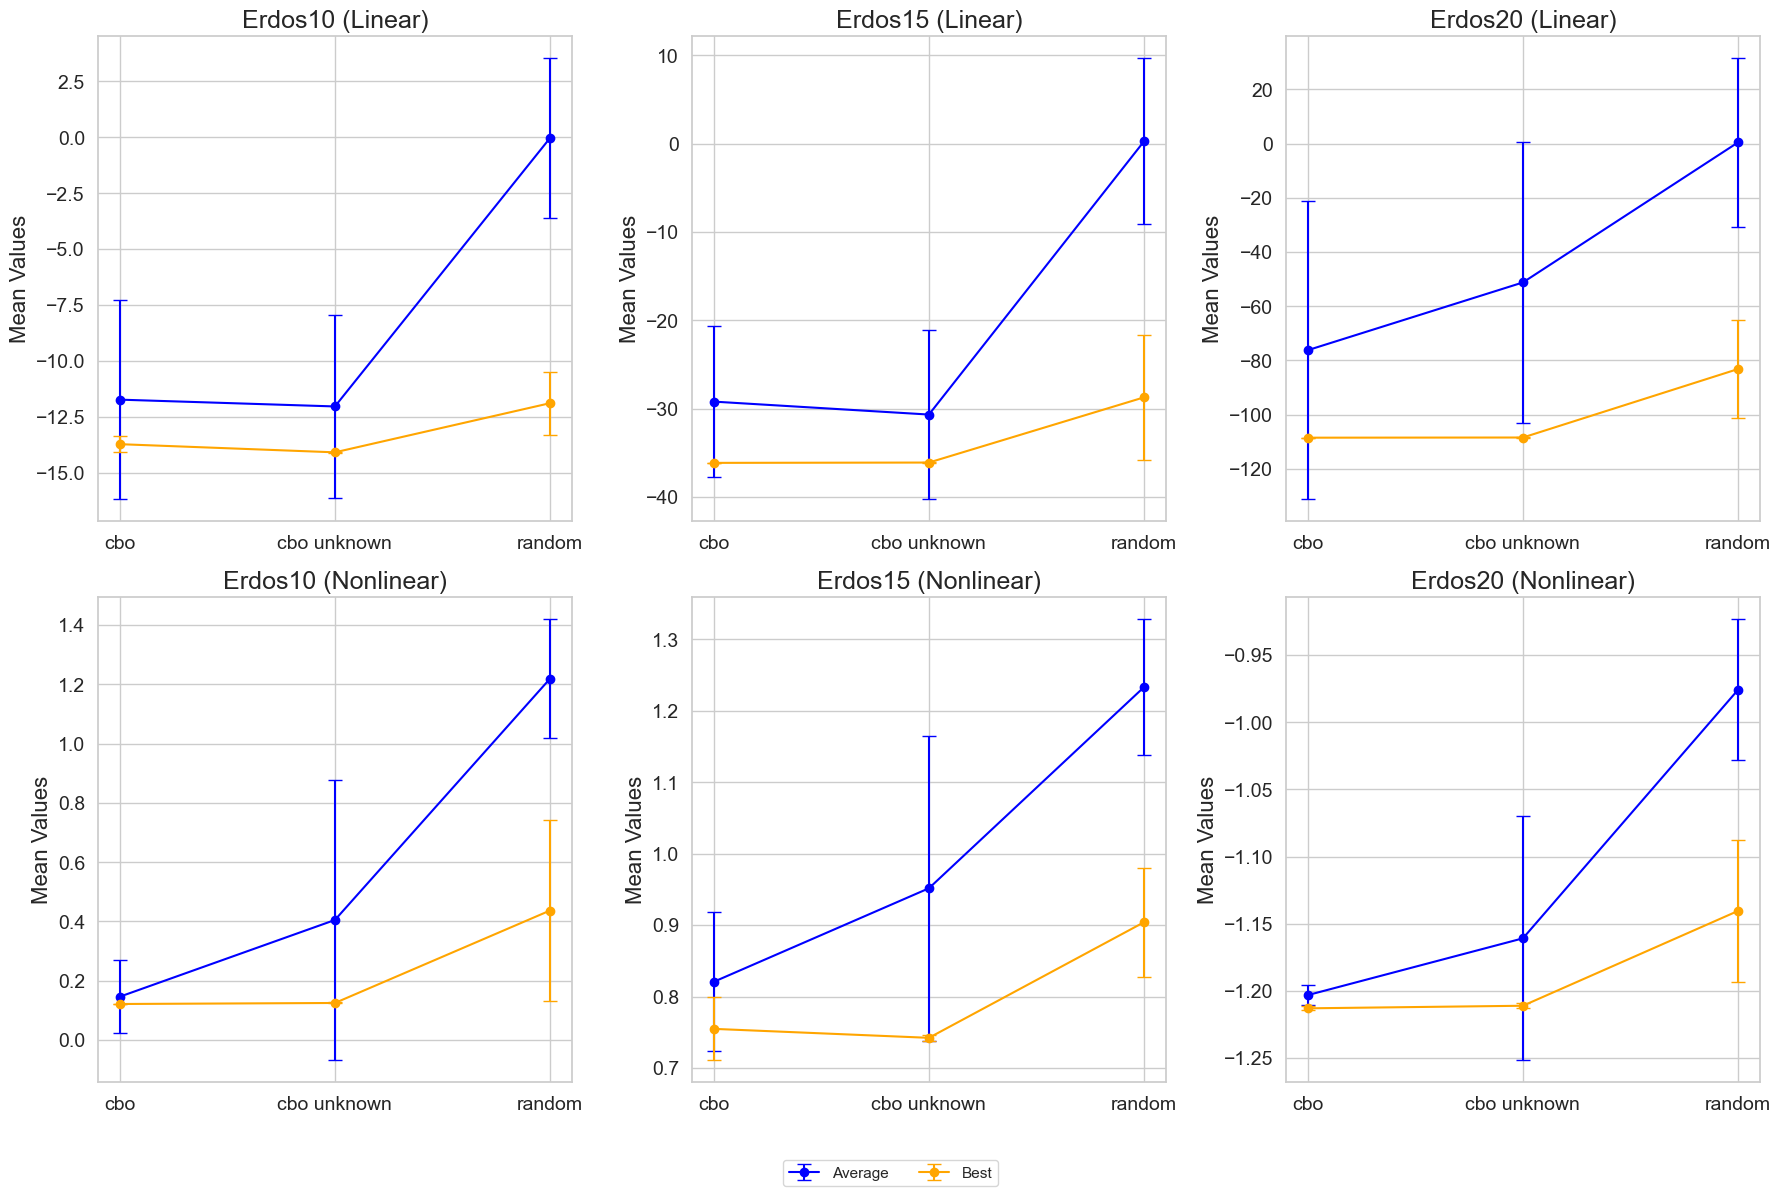

In [2]:
# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))

    return results


def all_means(
    base_path,
    n_obs=200,
    n_int=2,
    nonlinear: bool = False,
    has_all: bool = True,
    has_dr1: bool = True,
    has_dr2: bool = True,
    has_cbo: bool = True,
    has_random: bool = True,
):

    mean_results = {}
    nonlinear_string = "_nonlinear" if nonlinear else ""

    if has_cbo:
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        cbo_results = np.hstack(
            [cbo_result["Per_trial_Y"] for cbo_result in cbo_results]
        )
        cbo_mean = np.mean(cbo_results)
        cbo_std = np.std(cbo_results)
        mean_results["cbo"] = {"mean": cbo_mean, "std": cbo_std}

    if has_dr2:
        dr2_string = (
            rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        )
        dr2_results = load_results(base_path, dr2_string)
        dr2_results = np.hstack(
            [dr2_result["Per_trial_Y"] for dr2_result in dr2_results]
        )
        dr2_mean = np.mean(dr2_results)
        dr2_std = np.std(dr2_results)
        mean_results["dr2"] = {"mean": dr2_mean, "std": dr2_std}

    if has_random:
        random_string = (
            rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        )
        random_results = load_results(base_path, random_string)
        random_results = np.hstack(
            [random_result["Per_trial_Y"] for random_result in random_results]
        )
        random_mean = np.mean(random_results)
        random_std = np.std(random_results)
        mean_results["random"] = {"mean": random_mean, "std": random_std}

    return mean_results


def all_best(
    base_path,
    n_obs=200,
    n_int=2,
    nonlinear: bool = False,
    has_all: bool = True,
    has_dr1: bool = True,
    has_dr2: bool = True,
    has_cbo: bool = True,
    has_random: bool = True,
):

    min_results = {}
    nonlinear_string = "_nonlinear" if nonlinear else ""

    if has_cbo:
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        cbo_results = np.vstack([cbo_result["Best_Y"] for cbo_result in cbo_results])
        cbo_best_results = cbo_results.min(axis=1)
        cbo_mean = np.mean(cbo_best_results)
        cbo_std = np.std(cbo_best_results)
        min_results["cbo"] = {"mean": cbo_mean, "std": cbo_std}

    if has_dr2:
        dr2_string = (
            rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        )
        dr2_results = load_results(base_path, dr2_string)
        dr2_results = np.vstack([dr2_result["Best_Y"] for dr2_result in dr2_results])
        dr2_best_results = dr2_results.min(axis=1)
        dr2_mean = np.mean(dr2_best_results)
        dr2_std = np.std(dr2_best_results)
        min_results["dr2"] = {"mean": dr2_mean, "std": dr2_std}

    if has_random:
        random_string = (
            rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        )
        random_results = load_results(base_path, random_string)
        random_results = np.vstack(
            [random_result["Best_Y"] for random_result in random_results]
        )
        random_best_results = random_results.min(axis=1)
        random_mean = np.mean(random_best_results)
        random_std = np.std(random_best_results)
        min_results["random"] = {"mean": random_mean, "std": random_std}

    return min_results


def summarise_cbo_erdos_results(graphs: List = ["Erdos10", "Erdos15", "Erdos20"]):
    sns.set_theme(style="whitegrid")
    mean_results = {}
    min_results = {}

    # Extract linear results
    for graph in graphs:
        mean_results[graph] = all_means(graph, nonlinear=False)
        min_results[graph] = all_best(graph, nonlinear=False)

    # Function to extract data for plotting
    def extract_plot_data(data):
        methods = ["cbo", "dr2", "random"]
        means = []
        stds = []

        for method in methods:
            means.append(
                [
                    data["Erdos10"][method]["mean"],
                    data["Erdos15"][method]["mean"],
                    data["Erdos20"][method]["mean"],
                ]
            )
            stds.append(
                [
                    data["Erdos10"][method]["std"],
                    data["Erdos15"][method]["std"],
                    data["Erdos20"][method]["std"],
                ]
            )

        return methods, np.array(means).T, np.array(stds).T

    # Prepare plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    # axs.tick_params(axis="both", labelsize=14)

    experiments = ["Erdos10", "Erdos15", "Erdos20"]

    # Plot linear results on the top row
    methods, means1, stds1 = extract_plot_data(mean_results)
    _, means2, stds2 = extract_plot_data(min_results)

    methods = ["cbo", "cbo unknown", "random"]
    for i, experiment in enumerate(experiments):
        ax = axs[0, i]
        ax.tick_params(axis="both", labelsize=14)
        ax.errorbar(
            methods,
            means1[i],
            yerr=stds1[i],
            label="Average",
            marker="o",
            capsize=5,
            linestyle="-",
            color="blue",
        )
        ax.errorbar(
            methods,
            means2[i],
            yerr=stds2[i],
            label="Best",
            marker="o",
            capsize=5,
            linestyle="-",
            color="orange",
        )
        ax.set_title(f"{experiment} (Linear)", fontsize=18)
        ax.set_ylabel("Mean Values", fontsize=16)

    # Extract nonlinear results
    for graph in graphs:
        mean_results[graph] = all_means(graph, nonlinear=True)
        min_results[graph] = all_best(graph, nonlinear=True)

    # Plot nonlinear results on the bottom row
    methods, means1, stds1 = extract_plot_data(mean_results)
    _, means2, stds2 = extract_plot_data(min_results)

    methods = ["cbo", "cbo unknown", "random"]
    for i, experiment in enumerate(experiments):
        ax = axs[1, i]
        ax.tick_params(axis="both", labelsize=14)
        ax.errorbar(
            methods,
            means1[i],
            yerr=stds1[i],
            label="Average",
            marker="o",
            capsize=5,
            linestyle="-",
            color="blue",
        )
        ax.errorbar(
            methods,
            means2[i],
            yerr=stds2[i],
            label="Best",
            marker="o",
            capsize=5,
            linestyle="-",
            color="orange",
        )
        ax.set_title(f"{experiment} (Nonlinear)", fontsize=18)
        ax.set_ylabel("Mean Values", fontsize=16)

    # Add a single legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig("erdos_nonlinear_cbo.png")
    plt.show()
summarise_cbo_erdos_results()

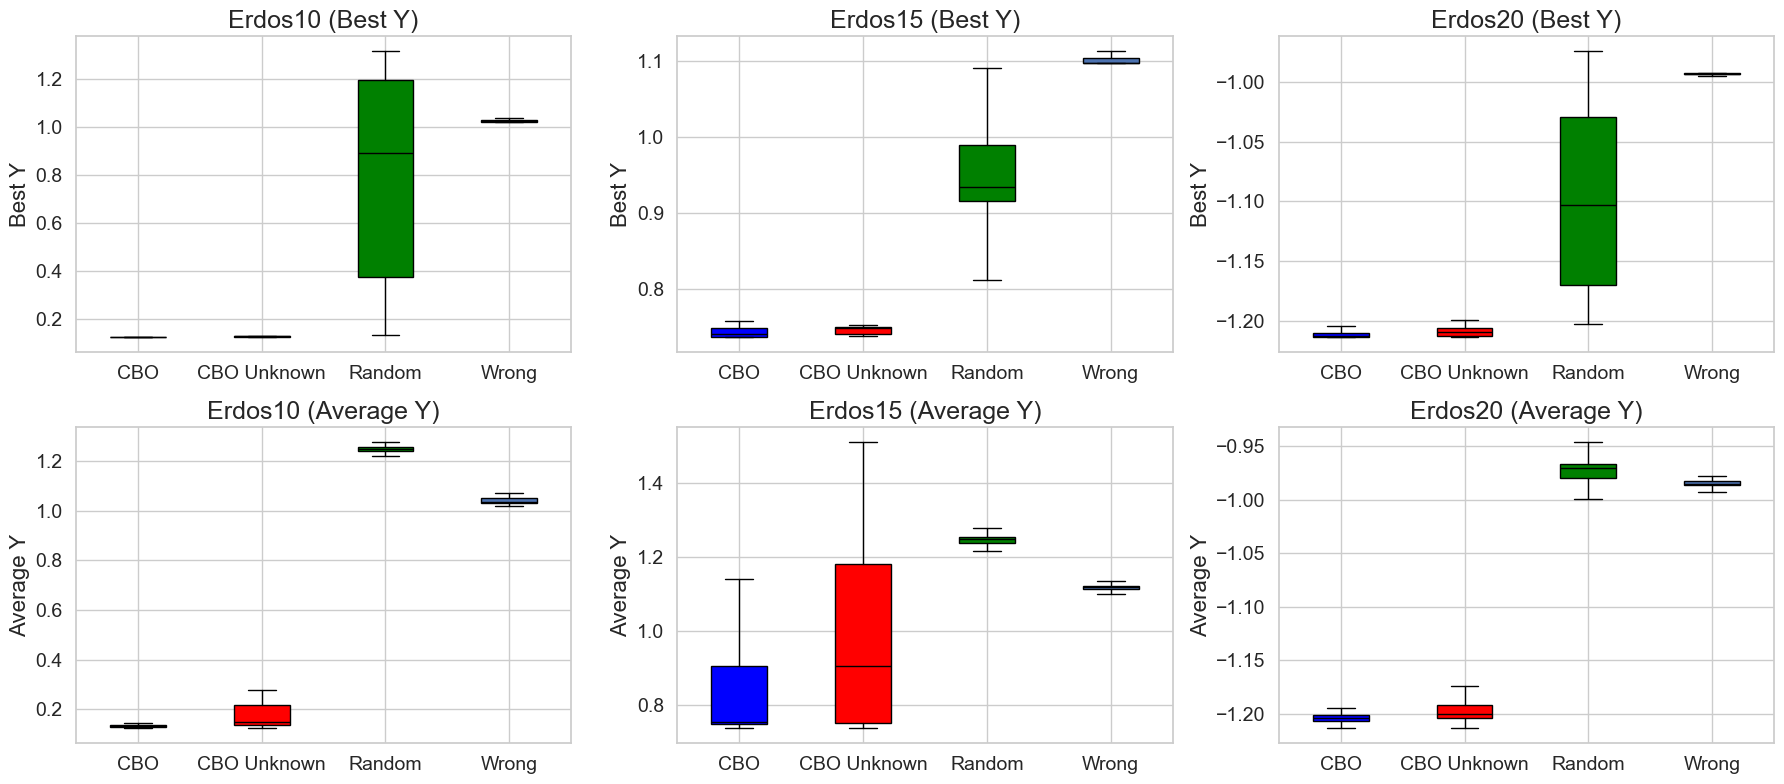

In [3]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to collect data for plotting
def collect_data(base_path, n_obs=200, n_int=2, nonlinear=True, methods=["cbo", "dr2", "random"]):
    data_results = {}
    nonlinear_string = "_nonlinear" if nonlinear else ""

    for method in methods:
        if method == "cbo":
            regex = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "dr2":
            regex = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "random":
            regex = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "misspecified":
            # continue
            regex = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        results = load_results(base_path, regex)
        per_trial_Y = np.hstack([result["Per_trial_Y"] for result in results])
        best_Y = np.hstack([result["Best_Y"] for result in results])
        data_results[method] = {"Per_trial_Y": per_trial_Y, "Best_Y": best_Y}

    return data_results

def summarise_cbo_erdos_results(graphs: List = ["Erdos10", "Erdos15", "Erdos20"]):
    sns.set_theme(style="whitegrid")
    methods = ["cbo", "dr2", "random", "misspecified"]
    display_methods = ["CBO", "CBO Unknown", "Random", "Wrong"]
    colors = ["blue", "red", "green"]
    data = {}

    # Collect nonlinear data for each graph
    for graph in graphs:
        data[graph] = collect_data(graph, nonlinear=True, methods=methods)

    # Prepare plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))

    for i, graph in enumerate(graphs):
        # Top row: Best Y
        ax = axs[0, i]
        ax.set_title(f"{graph} (Best Y)", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        data_to_plot = [data[graph][method]["Best_Y"] for method in methods]
        bp = ax.boxplot(
            data_to_plot,
            labels=display_methods,
            patch_artist=True,
            showfliers=False  # Remove outliers
        )

        # Set colors for each box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Set color for median lines
        for median in bp['medians']:
            median.set_color('black')

        ax.set_ylabel("Best Y", fontsize=16)

        # Bottom row: Average Y
        ax = axs[1, i]
        ax.set_title(f"{graph} (Average Y)", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        data_to_plot = [data[graph][method]["Per_trial_Y"] for method in methods]
        bp = ax.boxplot(
            data_to_plot,
            labels=display_methods,
            patch_artist=True,
            showfliers=False  # Remove outliers
        )

        # Set colors for each box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Set color for median lines
        for median in bp['medians']:
            median.set_color('black')

        ax.set_ylabel("Average Y", fontsize=16)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig("erdos_nonlinear_cbo_boxplots_colored.png")
    plt.show()

# Call the function to generate the plots
summarise_cbo_erdos_results()


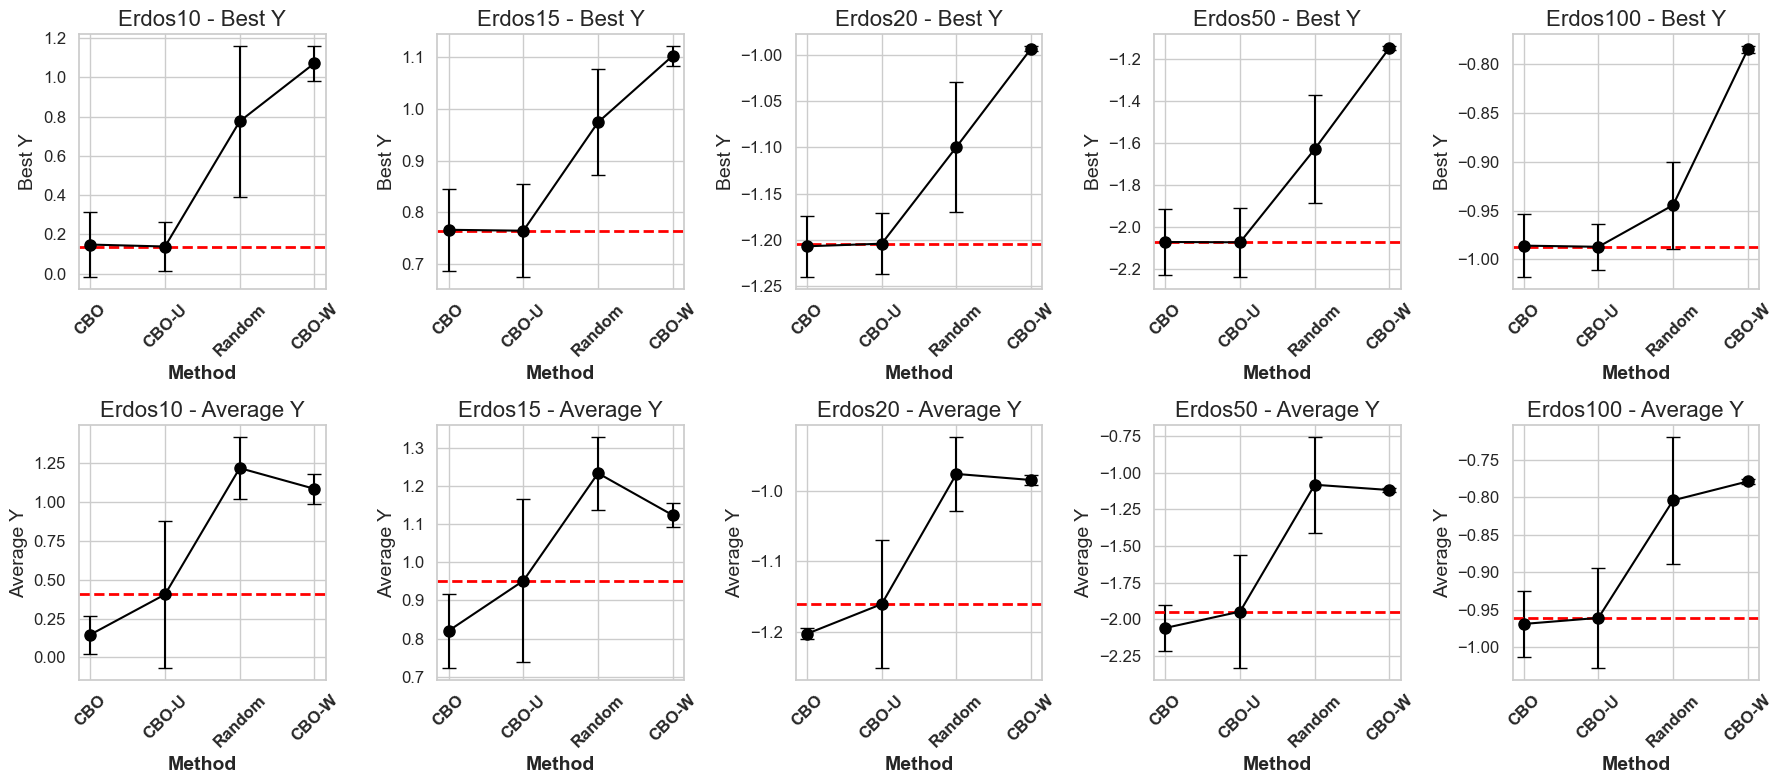

In [5]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to collect data for plotting
def collect_data(base_path, n_obs=200, n_int=2, nonlinear=True, methods=["cbo", "dr2", "random", "misspecified"]):
    data_results = {}
    nonlinear_string = "_nonlinear" if nonlinear else ""

    for method in methods:
        if method == "cbo":
            regex = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "dr2":
            regex = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "random":
            regex = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "misspecified":
            regex = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        results = load_results(base_path, regex)
        if results:
            per_trial_Y = np.hstack([result["Per_trial_Y"] for result in results])
            best_Y = np.hstack([result["Best_Y"] for result in results])
            data_results[method] = {"Per_trial_Y": per_trial_Y, "Best_Y": best_Y}
        else:
            data_results[method] = {"Per_trial_Y": np.array([]), "Best_Y": np.array([])}

    return data_results

def summarise_cbo_erdos_results(graphs: List = ["Erdos10", "Erdos15", "Erdos20", "Erdos50", "Erdos100_2"]):
    sns.set_theme(style="whitegrid")
    methods = ["cbo", "dr2", "random", "misspecified"]
    display_methods = ["CBO", "CBO-U", "Random", "CBO-W"]
    data = {}

    # Collect nonlinear data for each graph
    for graph in graphs:
        if graph != "Erdos100_2":
            data[graph] = collect_data(graph, nonlinear=True, methods=methods)
        else:
            data[graph] = collect_data(graph, nonlinear=True, methods=methods, n_obs=700)

    # Prepare plotting
    fig, axs = plt.subplots(2, 5, figsize=(18, 8))

    for i, graph in enumerate(graphs):
        # Top row: Best Y
        ax = axs[0, i]
        if graph == "Erdos100_2":
            graph_title = "Erdos100"
        else:
            graph_title = graph

        ax.set_title(f"{graph_title} - Best Y", fontsize=16)
        ax.tick_params(axis="both", labelsize=12)
        ax.set_xlabel("Method", fontsize=14, fontweight='bold')
        ax.set_ylabel("Best Y", fontsize=14)
        ax.grid(True)

        x_positions = np.arange(len(methods))
        means = []
        stds = []

        # Calculate means and stds for each method
        for idx, method in enumerate(methods):
            best_Y = data[graph][method]["Best_Y"]
            if best_Y.size > 0:
                mean = np.mean(best_Y)
                std = np.std(best_Y)
                means.append(mean)
                stds.append(std)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        # Get the mean value of CBO-U to plot the horizontal dashed line
        try:
            idx_cbo_u = methods.index('dr2')
            cbo_u_mean = means[idx_cbo_u]
        except ValueError:
            cbo_u_mean = None  # CBO-U data not available

        # Plot error bars for all methods in black and connect the means with lines
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Plot horizontal dashed line at the CBO-U mean
        if cbo_u_mean is not None and not np.isnan(cbo_u_mean):
            ax.axhline(y=cbo_u_mean, color='red', linestyle='--', linewidth=2)

        ax.set_xticks(x_positions)
        ax.set_xticklabels(display_methods, rotation=45, fontsize=12, fontweight='bold')

        # Bottom row: Average Y
        ax = axs[1, i]
        ax.set_title(f"{graph_title} - Average Y", fontsize=16)
        ax.tick_params(axis="both", labelsize=12)
        ax.set_xlabel("Method", fontsize=14, fontweight='bold')
        ax.set_ylabel("Average Y", fontsize=14)
        ax.grid(True)

        means = []
        stds = []

        # Calculate means and stds for each method
        for idx, method in enumerate(methods):
            per_trial_Y = data[graph][method]["Per_trial_Y"]
            if per_trial_Y.size > 0:
                mean = np.mean(per_trial_Y)
                std = np.std(per_trial_Y)
                means.append(mean)
                stds.append(std)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        # Get the mean value of CBO-U to plot the horizontal dashed line
        try:
            idx_cbo_u = methods.index('dr2')
            cbo_u_mean = means[idx_cbo_u]
        except ValueError:
            cbo_u_mean = None  # CBO-U data not available

        # Plot error bars for all methods in black and connect the means with lines
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Plot horizontal dashed line at the CBO-U mean
        if cbo_u_mean is not None and not np.isnan(cbo_u_mean):
            ax.axhline(y=cbo_u_mean, color='red', linestyle='--', linewidth=2)

        ax.set_xticks(x_positions)
        ax.set_xticklabels(display_methods, rotation=45, fontsize=12, fontweight='bold')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig("erdos_nonlinear_cbo_errorbars_separate.png")
    plt.show()

# Call the function to generate the plots
summarise_cbo_erdos_results()


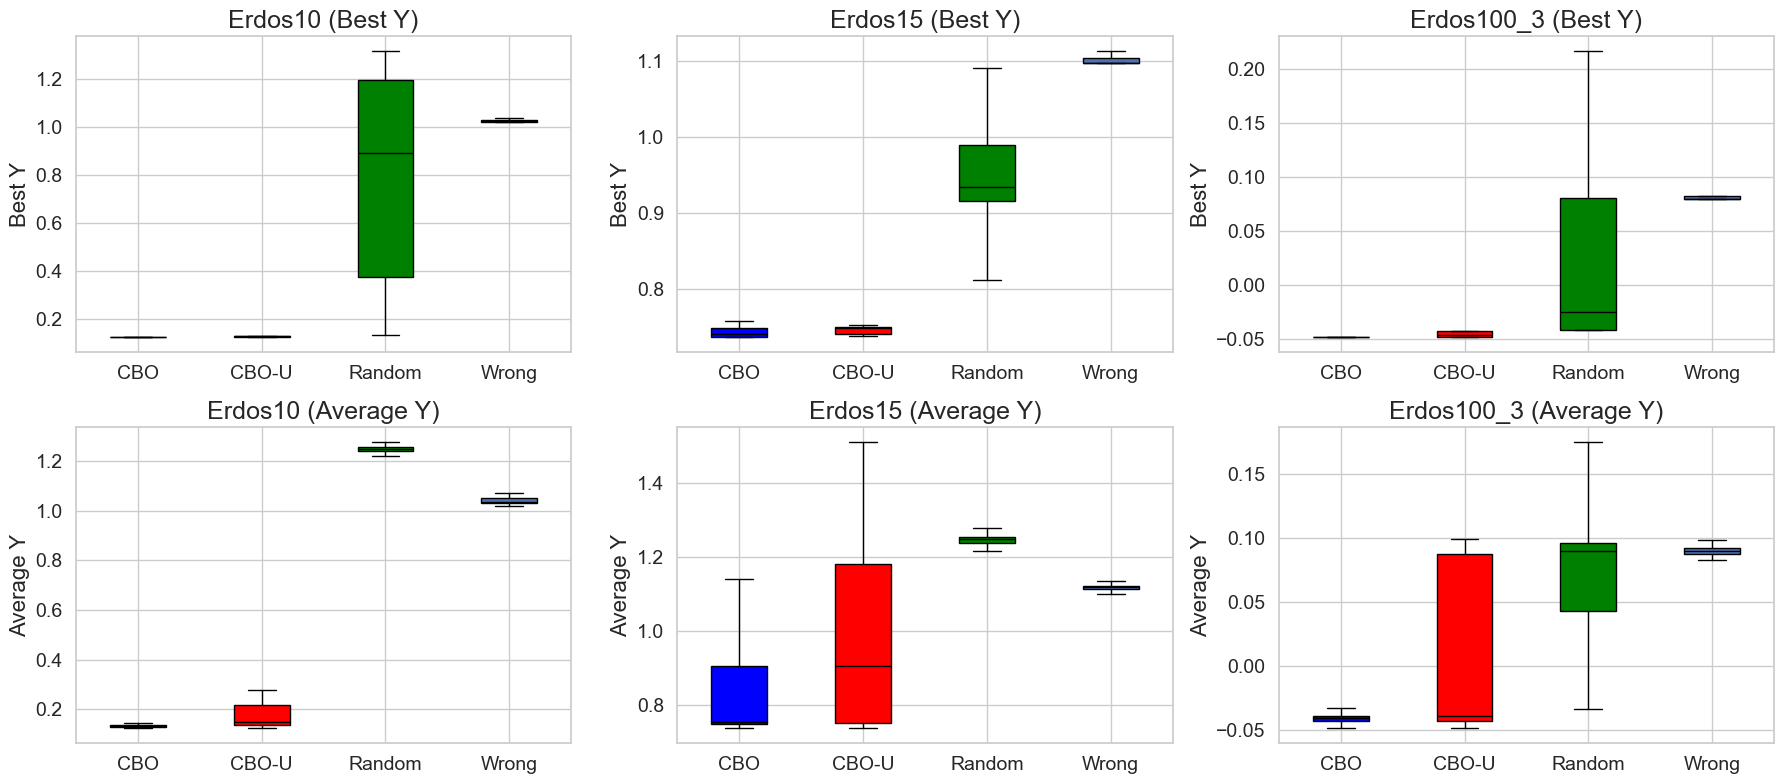

In [16]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to collect data for plotting
def collect_data(base_path, n_obs=200, n_int=2, nonlinear=True, methods=["cbo", "dr2", "random"]):
    data_results = {}
    nonlinear_string = "_nonlinear" if nonlinear else ""

    for method in methods:
        if method == "cbo":
            regex = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "dr2":
            regex = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "random":
            regex = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "misspecified":
            # continue
            regex = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        results = load_results(base_path, regex)
        per_trial_Y = np.hstack([result["Per_trial_Y"] for result in results])
        best_Y = np.hstack([result["Best_Y"] for result in results])
        data_results[method] = {"Per_trial_Y": per_trial_Y, "Best_Y": best_Y}
    return data_results

def summarise_cbo_erdos_results(graphs: List = ["Erdos10", "Erdos15", "Erdos100_3"]):
    sns.set_theme(style="whitegrid")
    methods = ["cbo", "dr2", "random", "misspecified"]
    display_methods = ["CBO", "CBO-U", "Random", "Wrong"]
    colors = ["blue", "red", "green"]
    data = {}

    # Collect nonlinear data for each graph
    for graph in graphs:
        if graph != "Erdos100_3":
            data[graph] = collect_data(graph, nonlinear=True, methods=methods)
        else:
            data[graph] = collect_data(graph, nonlinear=True, methods=methods, n_obs=500)

    # Prepare plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))

    for i, graph in enumerate(graphs):
        # Top row: Best Y
        ax = axs[0, i]
        ax.set_title(f"{graph} (Best Y)", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        data_to_plot = [data[graph][method]["Best_Y"] for method in methods]
        bp = ax.boxplot(
            data_to_plot,
            labels=display_methods,
            patch_artist=True,
            showfliers=False  # Remove outliers
        )

        # Set colors for each box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Set color for median lines
        for median in bp['medians']:
            median.set_color('black')

        ax.set_ylabel("Best Y", fontsize=16)

        # Bottom row: Average Y
        ax = axs[1, i]
        ax.set_title(f"{graph} (Average Y)", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        data_to_plot = [data[graph][method]["Per_trial_Y"] for method in methods]
        bp = ax.boxplot(
            data_to_plot,
            labels=display_methods,
            patch_artist=True,
            showfliers=False  # Remove outliers
        )

        # Set colors for each box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Set color for median lines
        for median in bp['medians']:
            median.set_color('black')

        ax.set_ylabel("Average Y", fontsize=16)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig("erdos_linear_cbo_boxplots_colored.png")
    plt.show()

# Call the function to generate the plots
summarise_cbo_erdos_results()

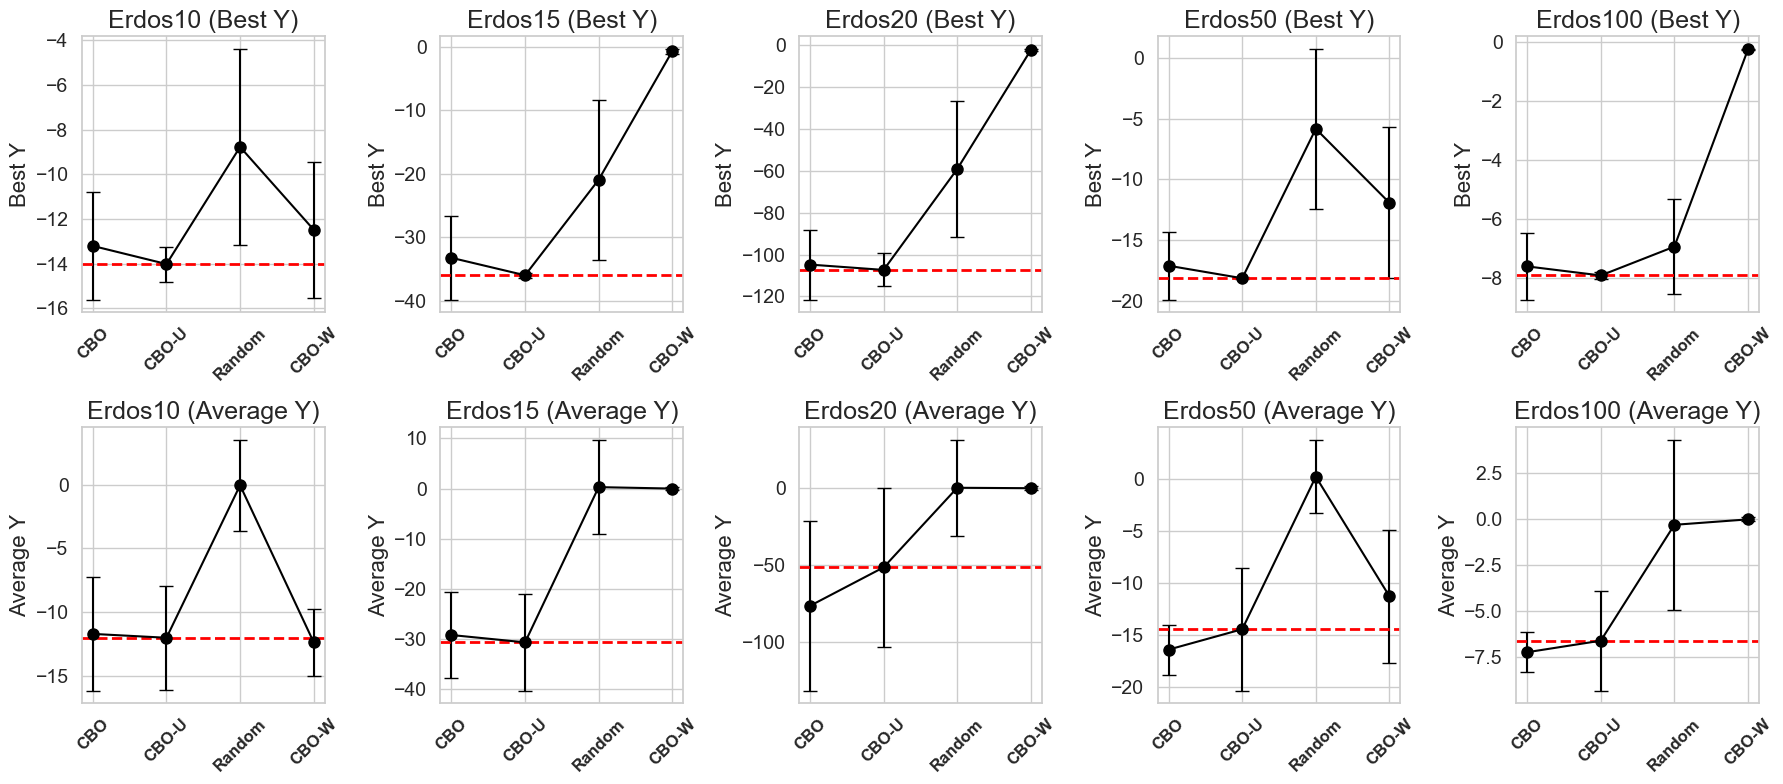

In [7]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to collect data for plotting
def collect_data(base_path, n_obs=200, n_int=2, nonlinear=False, methods=["cbo", "dr2", "random", "misspecified"]):
    data_results = {}
    nonlinear_string = "_nonlinear" if nonlinear else ""

    for method in methods:
        if method == "cbo":
            regex = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "dr2":
            regex = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "random":
            regex = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "misspecified":
            regex = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        results = load_results(base_path, regex)
        per_trial_Y = np.hstack([result["Per_trial_Y"] for result in results])
        best_Y = np.hstack([result["Best_Y"] for result in results])
        data_results[method] = {"Per_trial_Y": per_trial_Y, "Best_Y": best_Y}
    return data_results

def summarise_cbo_erdos_results(graphs: List = ["Erdos10", "Erdos15", "Erdos20", "Erdos50", "Erdos100_2"]):
    sns.set_theme(style="whitegrid")
    methods = ["cbo", "dr2", "random", "misspecified"]
    display_methods = ["CBO", "CBO-U", "Random", "CBO-W"]
    colors = ["blue", "red", "green", "orange"]
    data = {}

    # Collect data for each graph
    for graph in graphs:
        if graph != "Erdos100_2":
            data[graph] = collect_data(graph, nonlinear=False, methods=methods)
        else:
            data[graph] = collect_data(graph, nonlinear=False, methods=methods, n_obs=700)

    # Prepare plotting
    fig, axs = plt.subplots(2, 5, figsize=(18, 8))

    for i, graph in enumerate(graphs):
        # Top row: Best Y
        ax = axs[0, i]
        if graph == "Erdos100_2":
            graph_title = "Erdos100"
        else:
            graph_title = graph
        ax.set_title(f"{graph_title} (Best Y)", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        data_to_plot = [data[graph][method]["Best_Y"] for method in methods]
        means = [np.mean(d) if len(d) > 0 else np.nan for d in data_to_plot]
        stds = [np.std(d) if len(d) > 0 else np.nan for d in data_to_plot]
        x_positions = np.arange(len(methods))

        # Plot error bars with connected lines
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Plot horizontal dashed line at the mean value of CBO-U
        try:
            idx_cbo_u = methods.index('dr2')
            cbo_u_mean = means[idx_cbo_u]
            if not np.isnan(cbo_u_mean):
                ax.axhline(y=cbo_u_mean, color='red', linestyle='--', linewidth=2)
        except ValueError:
            pass  # CBO-U data not available

        ax.set_xticks(x_positions)
        ax.set_xticklabels(display_methods, rotation=45, fontsize=12, fontweight='bold')
        ax.set_ylabel("Best Y", fontsize=16)

        # Bottom row: Average Y
        ax = axs[1, i]
        ax.set_title(f"{graph_title} (Average Y)", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)

        data_to_plot = [data[graph][method]["Per_trial_Y"] for method in methods]
        means = [np.mean(d) if len(d) > 0 else np.nan for d in data_to_plot]
        stds = [np.std(d) if len(d) > 0 else np.nan for d in data_to_plot]
        x_positions = np.arange(len(methods))

        # Plot error bars with connected lines
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Plot horizontal dashed line at the mean value of CBO-U
        try:
            idx_cbo_u = methods.index('dr2')
            cbo_u_mean = means[idx_cbo_u]
            if not np.isnan(cbo_u_mean):
                ax.axhline(y=cbo_u_mean, color='red', linestyle='--', linewidth=2)
        except ValueError:
            pass  # CBO-U data not available

        ax.set_xticks(x_positions)
        ax.set_xticklabels(display_methods, rotation=45, fontsize=12, fontweight='bold')
        ax.set_ylabel("Average Y", fontsize=16)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig("erdos_linear_cbo_errorbars.png")
    plt.show()

# Call the function to generate the plots
summarise_cbo_erdos_results()


# Second experiment

/tmp/ipykernel_3337828/4199164360.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3337828/4199164360.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3337828/4199164360.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3337828/4199164360.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3337828/4199164360.py:106

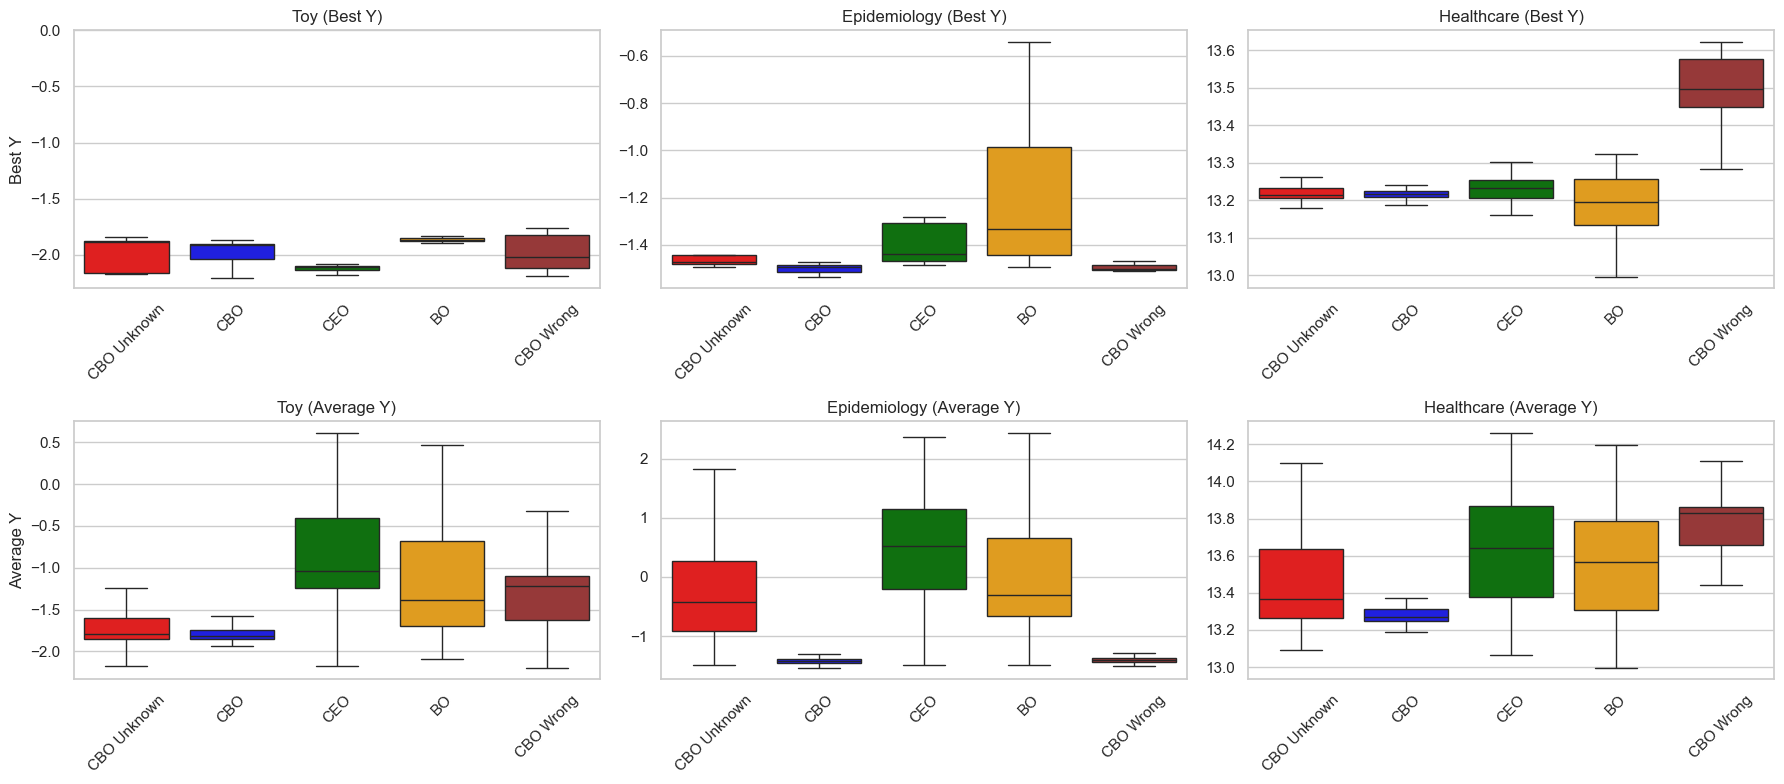

In [8]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to load all results of a given type
def load_results_regex(base_path, regex):
    results = []
    base_path, regex = regex.split("/")
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def extract_per_trial_data(regex_list):
    """
    Extracts all per trial Y data points from the results matching the regex list for use in box plots.
    """
    method_map = {0: "CBO Unknown", 1: "CBO", 2: "CEO", 3: "BO", 4: "CBO Wrong"}
    per_trial_data = {method: [] for method in method_map.values()}
    for i, regex in enumerate(regex_list):
        results = load_results_regex("", regex=regex)
        all_points = np.hstack([result["Per_trial_Y"][:30] for result in results])
        per_trial_data[method_map[i]].extend(all_points)
    return per_trial_data

def extract_best_y_data(regex_list):
    """
    Extracts the best Y data points from the results matching the regex list for use in box plots.
    """
    method_map = {0: "CBO Unknown", 1: "CBO", 2: "CEO", 3: "BO", 4: "CBO Wrong"}
    best_y_data = {method: [] for method in method_map.values()}
    for i, regex in enumerate(regex_list):
        results = load_results_regex("", regex=regex)
        best_results = np.vstack([result["Best_Y"][:30] for result in results]).min(axis=1)
        best_y_data[method_map[i]].extend(best_results)
    return best_y_data

def summarize_cbo_toy_results_with_boxplots():
    selected_graphs6 = [
        rf"Graph6Unknown/.*_cbo_dr_EI_results_200_2",
        rf"Graph6/.*_cbo_results_200_2_graph_0",
        rf"Graph6/.*ceo_\d*_results_200_2_",
        rf"Graph6/.*_bo_results_new_200_2_",
        rf"Graph6/.*_cbo_results_200_2_graph_4",
    ]
    selected_graphs5 = [
        rf"Graph5Unknown/.*_cbo_dr_EI_results_200_2",
        rf"Graph5/.*_cbo_results_200_2_graph_0",
        rf"Graph5/.*ceo_\d*_results_200_2_",
        rf"Graph5Wrong/.*_bo_results_new_200_2_",
        rf"Graph5_blanket/.*_cbo_results_200_2_graph_0",
    ]
    selected_toy = [
        rf"ToyGraphUnknown/.*_cbo_dr_EI_results_200_2",
        rf"ToyGraph/.*_cbo_results_200_2_graph_0",
        rf"ToyGraph/.*ceo_\d*_results_200_2_",
        rf"ToyGraph/.*_bo_results_new_200_2_",
        rf"ToyGraph/.*_cbo_results_200_2_graph_6",
    ]

    sns.set_theme(style="whitegrid")

    # Gather data for box plots
    per_trial_data = {
        "ToyGraph": extract_per_trial_data(selected_toy),
        "Graph5": extract_per_trial_data(selected_graphs5),
        "Graph6": extract_per_trial_data(selected_graphs6),
    }

    best_y_data = {
        "ToyGraph": extract_best_y_data(selected_toy),
        "Graph5": extract_best_y_data(selected_graphs5),
        "Graph6": extract_best_y_data(selected_graphs6),
    }

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows, 3 columns

    # Experiment names for titles
    experiments = ["ToyGraph", "Graph5", "Graph6"]
    titles = ["Toy", "Epidemiology", "Healthcare"]

    methods = ["CBO Unknown", "CBO", "CEO", "BO", "CBO Wrong"]
    method_colors = {"CBO Unknown": "red", "CBO": "blue", "CEO": "green", "BO": "orange", "CBO Wrong":"brown"}

    for i, experiment in enumerate(experiments):
        # Top row: Best Y
        ax_top = axs[0, i]
        best_data = best_y_data[experiment]

        # Prepare data for seaborn boxplot
        best_plot_data = []
        for method in methods:
            values = best_data.get(method, [])
            best_plot_data.append(pd.DataFrame({
                'Method': [method] * len(values),
                'Value': values
            }))
        best_plot_data = pd.concat(best_plot_data)

        sns.boxplot(
            ax=ax_top,
            x="Method",
            y="Value",
            data=best_plot_data,
            palette=method_colors,
            showfliers=False
        )
        ax_top.set_title(f"{titles[i]} (Best Y)")
        ax_top.set_ylabel("Best Y" if i == 0 else "")
        ax_top.set_xlabel("")
        ax_top.tick_params(axis='x', rotation=45)

        # **Adjust y-axis limits for the top-left plot**
        if i == 0:
            ax_top.set_ylim(-2.3, 0)  # Set y-axis limits from -2.3 to 0

        # Bottom row: Average Y
        ax_bottom = axs[1, i]
        per_trial = per_trial_data[experiment]

        # Prepare data for seaborn boxplot
        per_trial_plot_data = []
        for method in methods:
            values = per_trial.get(method, [])
            per_trial_plot_data.append(pd.DataFrame({
                'Method': [method] * len(values),
                'Value': values
            }))
        per_trial_plot_data = pd.concat(per_trial_plot_data)

        sns.boxplot(
            ax=ax_bottom,
            x="Method",
            y="Value",
            data=per_trial_plot_data,
            palette=method_colors,
            showfliers=False
        )
        ax_bottom.set_title(f"{titles[i]} (Average Y)")
        ax_bottom.set_ylabel("Average Y" if i == 0 else "")
        ax_bottom.set_xlabel("")
        ax_bottom.tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig("toy_summary_boxplots_best_and_average.png", bbox_inches="tight")
    plt.show()

summarize_cbo_toy_results_with_boxplots()


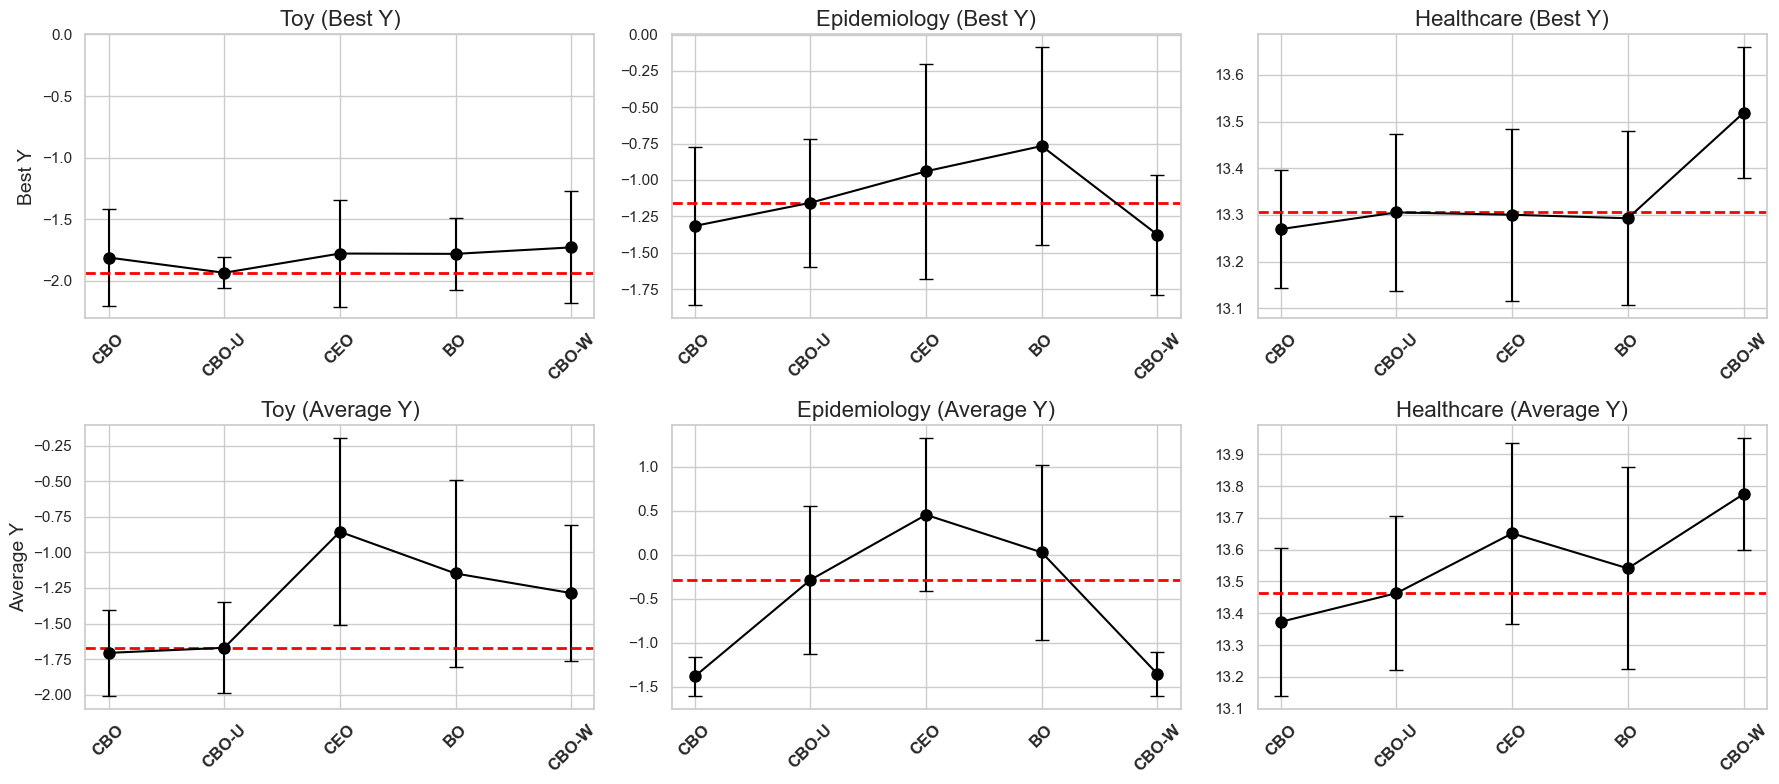

In [9]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to load all results of a given type
def load_results_regex(base_path, regex):
    results = []
    base_path, regex = regex.split("/", 1)  # Adjusted to split only once
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def extract_per_trial_data(regex_list):
    """
    Extracts all per trial Y data points from the results matching the regex list for use in plots.
    """
    # Rearranged method_map to have "CBO" first and "CBO Unknown" second
    method_map = {0: "CBO", 1: "CBO-U", 2: "CEO", 3: "BO", 4: "CBO-W"}
    per_trial_data = {method: [] for method in method_map.values()}
    for i, regex in enumerate(regex_list):
        results = load_results_regex("", regex=regex)
        # Collecting mean and std for error bars
        all_points = [result["Per_trial_Y"][:30] for result in results]
        per_trial_data[method_map[i]].extend(all_points)
    return per_trial_data

def extract_best_y_data(regex_list):
    """
    Extracts the best Y data points from the results matching the regex list for use in plots.
    """
    # Rearranged method_map to have "CBO" first and "CBO Unknown" second
    method_map = {0: "CBO", 1: "CBO-U", 2: "CEO", 3: "BO", 4: "CBO-W"}
    best_y_data = {method: [] for method in method_map.values()}
    for i, regex in enumerate(regex_list):
        results = load_results_regex("", regex=regex)
        # Collecting mean and std for error bars
        best_results = [result["Best_Y"][:30] for result in results]
        best_y_data[method_map[i]].extend(best_results)
    return best_y_data

def summarize_cbo_toy_results_with_errorbars():
    # Rearranged regex lists to match the new method order
    selected_graphs6 = [
        rf"Graph6/.*_cbo_results_200_2_graph_0",            # CBO
        rf"Graph6Unknown/.*_cbo_dr_EI_results_200_2",       # CBO Unknown
        rf"Graph6/.*ceo_\d*_results_200_2_",                # CEO
        rf"Graph6/.*_bo_results_new_200_2_",                # BO
        rf"Graph6/.*_cbo_results_200_2_graph_4",            # CBO Wrong
    ]
    selected_graphs5 = [
        rf"Graph5/.*_cbo_results_200_2_graph_0",            # CBO
        rf"Graph5Unknown/.*_cbo_dr_EI_results_200_2",       # CBO Unknown
        rf"Graph5/.*ceo_\d*_results_200_2_",                # CEO
        rf"Graph5Wrong/.*_bo_results_new_200_2_",           # BO
        rf"Graph5_blanket/.*_cbo_results_200_2_graph_0",    # CBO Wrong
    ]
    selected_toy = [
        rf"ToyGraph/.*_cbo_results_200_2_graph_0",          # CBO
        rf"ToyGraphUnknown/.*_cbo_dr_EI_results_200_2",     # CBO Unknown
        rf"ToyGraph/.*ceo_\d*_results_200_2_",              # CEO
        rf"ToyGraph/.*_bo_results_new_200_2_",              # BO
        rf"ToyGraph/.*_cbo_results_200_2_graph_6",          # CBO Wrong
    ]

    sns.set_theme(style="whitegrid")

    # Gather data for plots
    per_trial_data = {
        "ToyGraph": extract_per_trial_data(selected_toy),
        "Graph5": extract_per_trial_data(selected_graphs5),
        "Graph6": extract_per_trial_data(selected_graphs6),
    }

    best_y_data = {
        "ToyGraph": extract_best_y_data(selected_toy),
        "Graph5": extract_best_y_data(selected_graphs5),
        "Graph6": extract_best_y_data(selected_graphs6),
    }

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows, 3 columns

    # Experiment names for titles
    experiments = ["ToyGraph", "Graph5", "Graph6"]
    titles = ["Toy", "Epidemiology", "Healthcare"]

    methods = ["CBO", "CBO-U", "CEO", "BO", "CBO-W"]
    method_colors = {"CBO": "blue", "CBO-U": "red", "CEO": "green", "BO": "orange", "CBO-W": "brown"}

    for i, experiment in enumerate(experiments):
        # Top row: Best Y
        ax_top = axs[0, i]
        best_data = best_y_data[experiment]

        means = []
        stds = []
        for method in methods:
            values = np.hstack(best_data.get(method, []))
            mean = np.mean(values) if len(values) > 0 else np.nan
            std = np.std(values) if len(values) > 0 else np.nan
            means.append(mean)
            stds.append(std)

        x_positions = np.arange(len(methods))

        # Plot error bars with connected lines
        ax_top.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Plot horizontal dashed line at the mean value of CBO Unknown
        try:
            idx_cbo_unknown = methods.index('CBO-U')
            cbo_unknown_mean = means[idx_cbo_unknown]
            if not np.isnan(cbo_unknown_mean):
                ax_top.axhline(y=cbo_unknown_mean, color='red', linestyle='--', linewidth=2)
        except ValueError:
            pass  # CBO Unknown data not available

        ax_top.set_xticks(x_positions)
        ax_top.set_xticklabels(methods, rotation=45, fontsize=12, fontweight='bold')
        ax_top.set_title(f"{titles[i]} (Best Y)", fontsize=16)
        ax_top.set_ylabel("Best Y" if i == 0 else "", fontsize=14)
        ax_top.grid(True)

        # **Adjust y-axis limits for the top-left plot**
        if i == 0:
            ax_top.set_ylim(-2.3, 0)  # Set y-axis limits from -2.3 to 0

        # Bottom row: Average Y
        ax_bottom = axs[1, i]
        per_trial = per_trial_data[experiment]

        means = []
        stds = []
        for method in methods:
            values = np.hstack(per_trial.get(method, []))
            mean = np.mean(values) if len(values) > 0 else np.nan
            std = np.std(values) if len(values) > 0 else np.nan
            means.append(mean)
            stds.append(std)

        # Plot error bars with connected lines
        ax_bottom.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Plot horizontal dashed line at the mean value of CBO Unknown
        try:
            idx_cbo_unknown = methods.index('CBO-U')
            cbo_unknown_mean = means[idx_cbo_unknown]
            if not np.isnan(cbo_unknown_mean):
                ax_bottom.axhline(y=cbo_unknown_mean, color='red', linestyle='--', linewidth=2)
        except ValueError:
            pass  # CBO Unknown data not available

        ax_bottom.set_xticks(x_positions)
        ax_bottom.set_xticklabels(methods, rotation=45, fontsize=12, fontweight='bold')
        ax_bottom.set_title(f"{titles[i]} (Average Y)", fontsize=16)
        ax_bottom.set_ylabel("Average Y" if i == 0 else "", fontsize=14)
        ax_bottom.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig("toy_summary_errorbars_best_and_average.png", bbox_inches="tight")
    plt.show()

summarize_cbo_toy_results_with_errorbars()


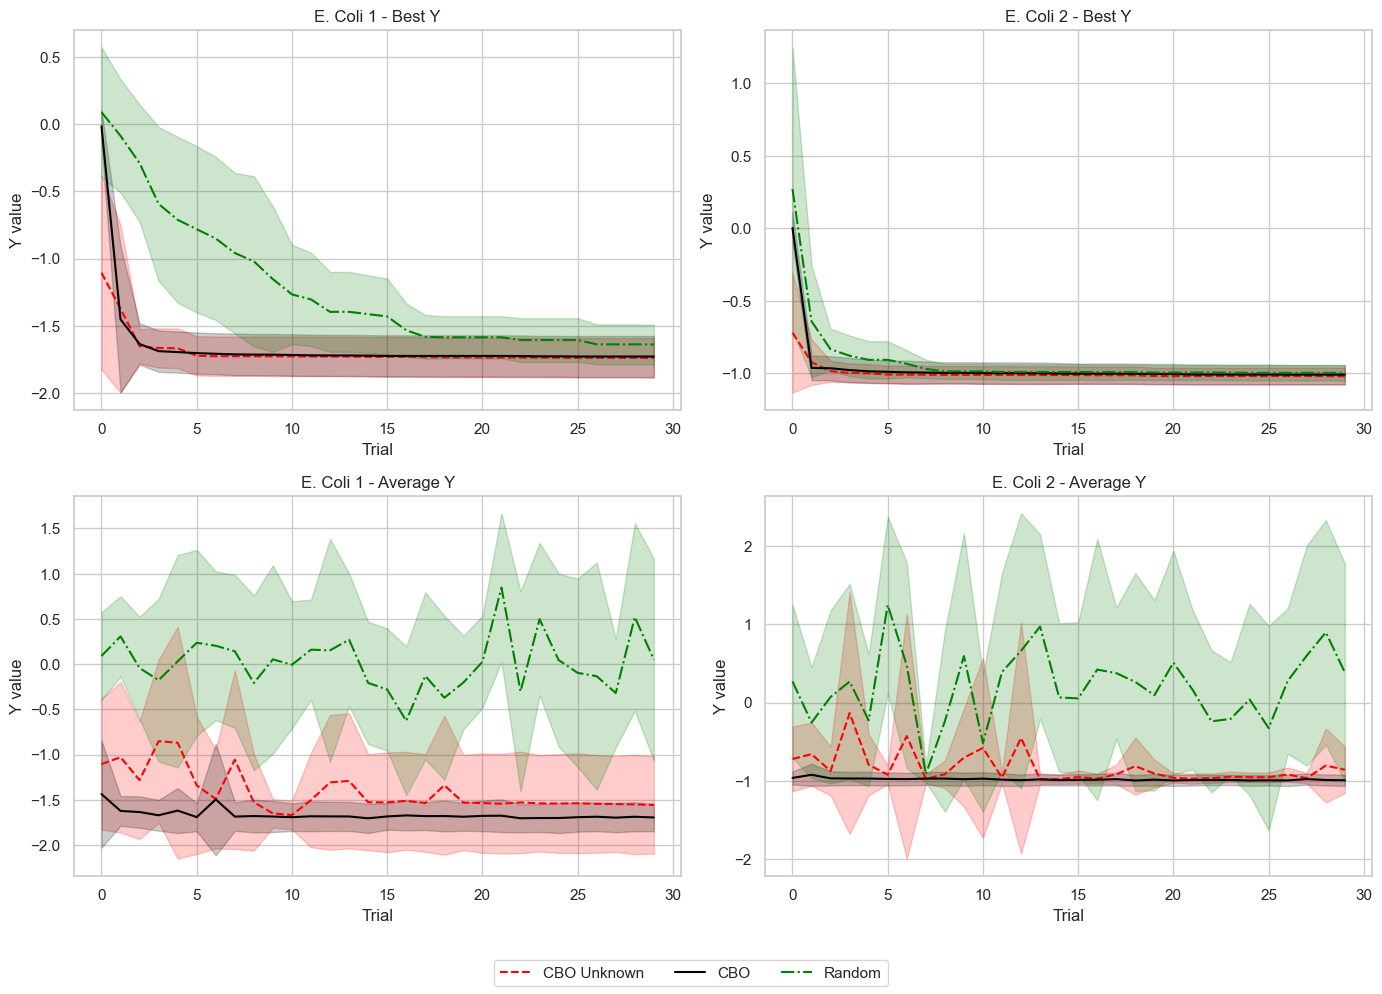

In [10]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment][:30] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

def plot_everything(ax, base_path, experiment, n_obs=200, n_int=1, nonlinear=False,
                    plot_cbo=True, plot_dr2=True, plot_random=True):
    sns.set_theme(style="whitegrid")
    nonlinear_string = "_nonlinear" if nonlinear else ""
    colors = {"CBO": "black", "CBO Unknown": "red", "Random": "green"}
    line_styles = {"CBO": "-", "CBO Unknown": "--", "Random": "-."}

    if plot_dr2:
        # Load and aggregate results for CBO Unknown
        dr2_string = rf".*_cbo_unknown_dr2_iscm_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        dr2_results = load_results(base_path, dr2_string)
        if dr2_results:
            dr2_mean, dr2_std = aggregate_results(dr2_results, experiment)
            x_values = range(len(dr2_mean))
            ax.fill_between(x_values, dr2_mean - dr2_std, dr2_mean + dr2_std, alpha=0.2, color=colors["CBO Unknown"])
            ax.plot(x_values, dr2_mean, label="CBO Unknown", color=colors["CBO Unknown"], linestyle=line_styles["CBO Unknown"])
    
    if plot_cbo:
        # Load and aggregate results for CBO
        cbo_string = rf".*_cbo_results_iscm_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        if cbo_results:
            cbo_mean, cbo_std = aggregate_results(cbo_results, experiment)
            x_values = range(len(cbo_mean))
            ax.fill_between(x_values, cbo_mean - cbo_std, cbo_mean + cbo_std, alpha=0.2, color=colors["CBO"])
            ax.plot(x_values, cbo_mean, label="CBO", color=colors["CBO"], linestyle=line_styles["CBO"])
    
    if plot_random:
        # Load and aggregate results for Random
        random_string = rf".*_cbo_results_random_iscm_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        if random_results:
            random_mean, random_std = aggregate_results(random_results, experiment)
            x_values = range(len(random_mean))
            ax.fill_between(x_values, random_mean - random_std, random_mean + random_std, alpha=0.2, color=colors["Random"])
            ax.plot(x_values, random_mean, label="Random", color=colors["Random"], linestyle=line_styles["Random"])
    
    ax.set_xlabel("Trial")
    ax.set_ylabel("Y value")
    ax.grid(True)
    return ax

def summarise_ecoli_results():
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Top row: Best Y
    # Left column: Ecoli1
    plot_everything(axs[0, 0], base_path="Ecoli1", experiment="Best_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[0, 0].set_title("E. Coli 1 - Best Y")

    # Right column: Ecoli2
    plot_everything(axs[0, 1], base_path="Ecoli2", experiment="Best_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[0, 1].set_title("E. Coli 2 - Best Y")

    # Bottom row: Average Y
    # Left column: Ecoli1
    plot_everything(axs[1, 0], base_path="Ecoli1", experiment="Per_trial_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[1, 0].set_title("E. Coli 1 - Average Y")

    # Right column: Ecoli2
    plot_everything(axs[1, 1], base_path="Ecoli2", experiment="Per_trial_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[1, 1].set_title("E. Coli 2 - Average Y")

    # Remove duplicate legends and only show one legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)

    # # Remove legends from individual plots
    # for ax in axs.flatten():
    #     ax.get_legend().remove()

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli_summary_with_linestyles.png", bbox_inches="tight")
    plt.show()

# Call the function to create the plots
summarise_ecoli_results()


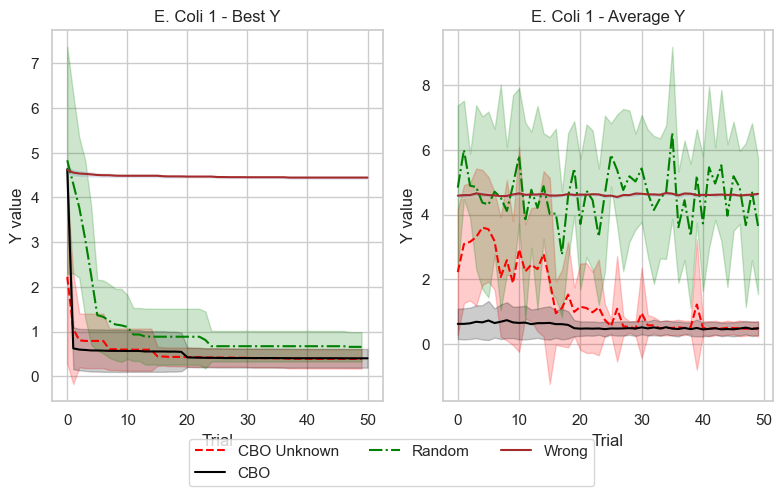

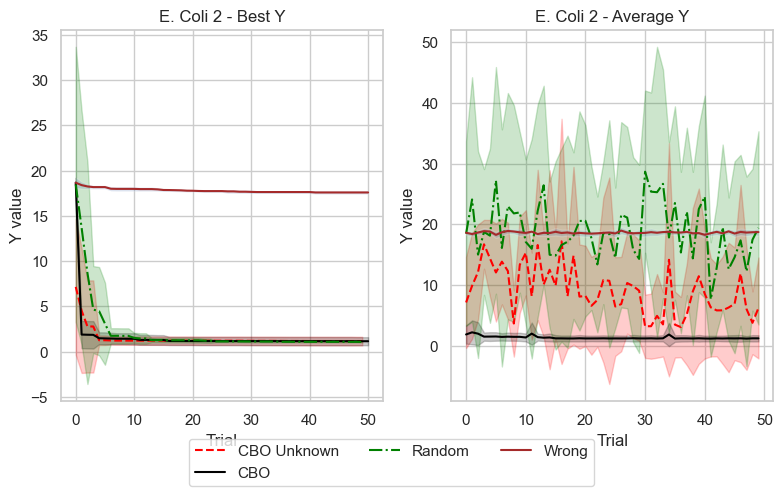

In [11]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

def plot_everything(ax, base_path, experiment, n_obs=200, n_int=1, nonlinear=False,
                    plot_cbo=True, plot_dr2=True, plot_random=True, plot_misspecified=True):
    sns.set_theme(style="whitegrid")
    nonlinear_string = "_nonlinear" if nonlinear else ""
    colors = {"CBO": "black", "CBO Unknown": "red", "Random": "green", "Wrong": "brown"}
    line_styles = {"CBO": "-", "CBO Unknown": "--", "Random": "-."}

    if plot_dr2:
        # Load and aggregate results for CBO Unknown
        dr2_string = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        dr2_results = load_results(base_path, dr2_string)
        if dr2_results:
            dr2_mean, dr2_std = aggregate_results(dr2_results, experiment)
            x_values = range(len(dr2_mean))
            ax.fill_between(x_values, dr2_mean - dr2_std, dr2_mean + dr2_std, alpha=0.2, color=colors["CBO Unknown"])
            ax.plot(x_values, dr2_mean, label="CBO Unknown", color=colors["CBO Unknown"], linestyle=line_styles["CBO Unknown"])
    
    if plot_cbo:
        # Load and aggregate results for CBO
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        if cbo_results:
            cbo_mean, cbo_std = aggregate_results(cbo_results, experiment)
            x_values = range(len(cbo_mean))
            ax.fill_between(x_values, cbo_mean - cbo_std, cbo_mean + cbo_std, alpha=0.2, color=colors["CBO"])
            ax.plot(x_values, cbo_mean, label="CBO", color=colors["CBO"], linestyle=line_styles["CBO"])
    
    if plot_random:
        # Load and aggregate results for Random
        random_string = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        if random_results:
            random_mean, random_std = aggregate_results(random_results, experiment)
            x_values = range(len(random_mean))
            ax.fill_between(x_values, random_mean - random_std, random_mean + random_std, alpha=0.2, color=colors["Random"])
            ax.plot(x_values, random_mean, label="Random", color=colors["Random"], linestyle=line_styles["Random"])

    if plot_misspecified:
        # Load and aggregate results for Random
        random_string = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        if random_results:
            random_mean, random_std = aggregate_results(random_results, experiment)
            x_values = range(len(random_mean))
            ax.fill_between(x_values, random_mean - random_std, random_mean + random_std, alpha=0.2)
            ax.plot(x_values, random_mean, label="Wrong", color=colors["Wrong"])
    
    ax.set_xlabel("Trial")
    ax.set_ylabel("Y value")
    ax.grid(True)
    return ax

def summarise_ecoli1_results():
    fig, axs = plt.subplots(1, 2, figsize=(8, 5))  # One row, two columns

    # Left plot: Best Y
    plot_everything(axs[0], base_path="Ecoli1", experiment="Best_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[0].set_title("E. Coli 1 - Best Y")

    # Right plot: Average Y
    plot_everything(axs[1], base_path="Ecoli1", experiment="Per_trial_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[1].set_title("E. Coli 1 - Average Y")

    # Single legend for both plots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)



    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli1_summary.png", bbox_inches="tight")
    plt.show()

def summarise_ecoli2_results():
    fig, axs = plt.subplots(1, 2, figsize=(8, 5))  # One row, two columns

    # Left plot: Best Y
    plot_everything(axs[0], base_path="Ecoli2", experiment="Best_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[0].set_title("E. Coli 2 - Best Y")

    # Right plot: Average Y
    plot_everything(axs[1], base_path="Ecoli2", experiment="Per_trial_Y", n_obs=200, n_int=1,
                    plot_cbo=True, plot_dr2=True, plot_random=True)
    axs[1].set_title("E. Coli 2 - Average Y")

    # Single legend for both plots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)

  
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli2_summary.png", bbox_inches="tight")
    plt.show()

# Call the functions to create and save the figures
summarise_ecoli1_results()
summarise_ecoli2_results()


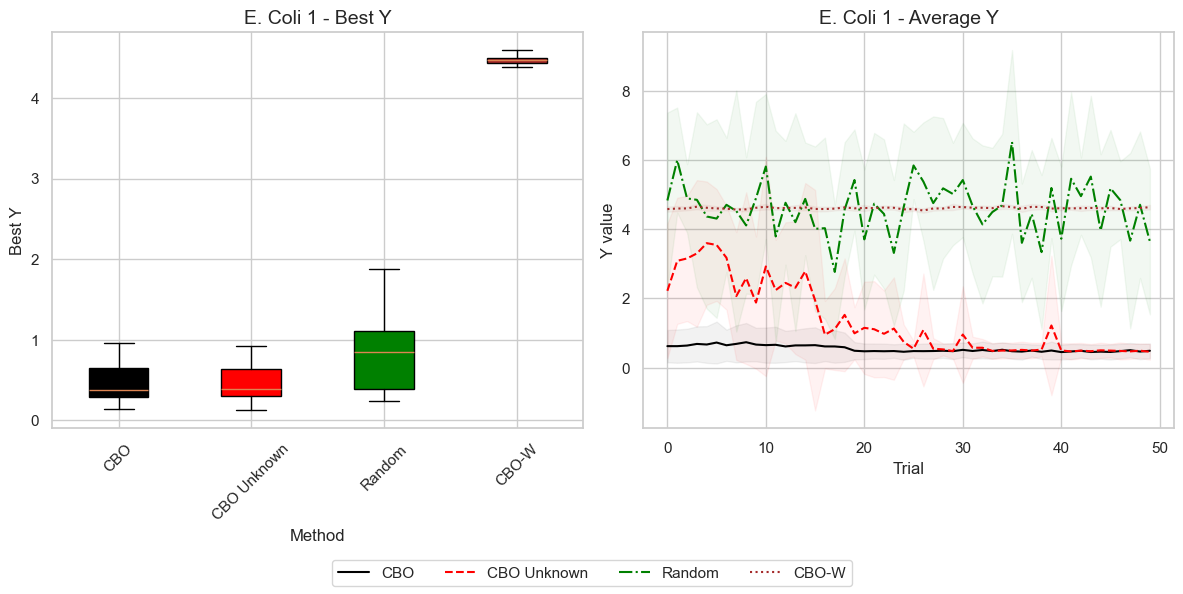

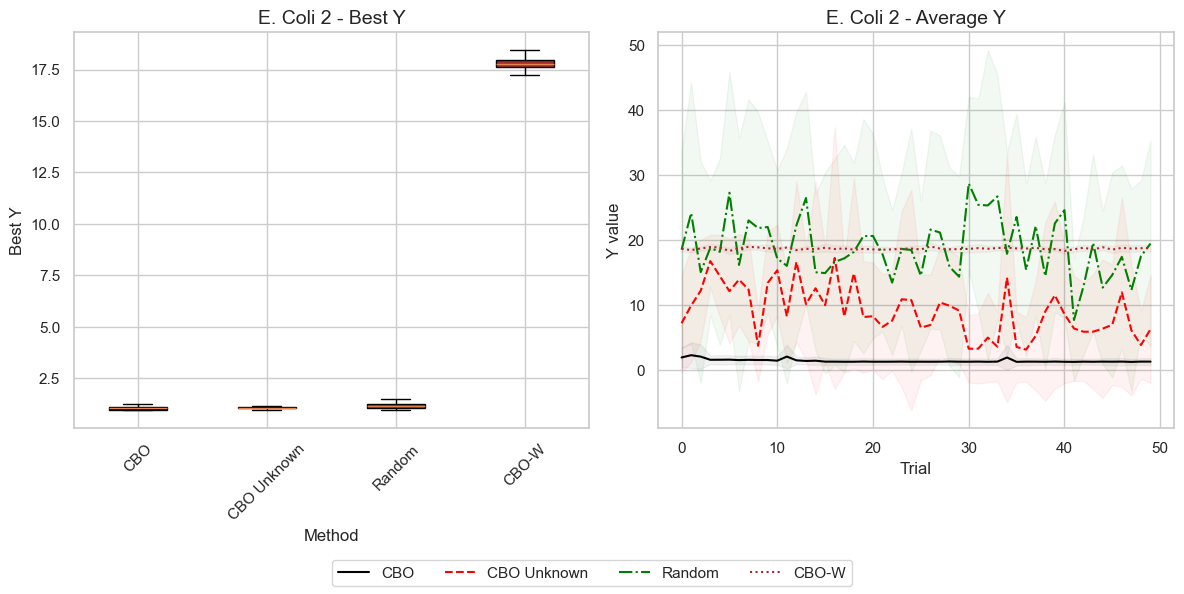

In [12]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

def plot_everything(ax, base_path, experiment, n_obs=200, n_int=1, nonlinear=False,
                    plot_cbo=True, plot_dr2=True, plot_random=True, plot_misspecified=True):
    sns.set_theme(style="whitegrid")
    nonlinear_string = "_nonlinear" if nonlinear else ""
    colors = {"CBO": "black", "CBO Unknown": "red", "Random": "green", "CBO-W": "brown"}
    line_styles = {"CBO": "-", "CBO Unknown": "--", "Random": "-.", "CBO-W": ":"}
    methods = []
    data_results = {}

    if plot_cbo:
        methods.append("CBO")
        # Load results for CBO
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        data_results["CBO"] = cbo_results

    if plot_dr2:
        methods.append("CBO Unknown")
        # Load results for CBO Unknown
        dr2_string = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        dr2_results = load_results(base_path, dr2_string)
        data_results["CBO Unknown"] = dr2_results

    if plot_random:
        methods.append("Random")
        # Load results for Random
        random_string = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        data_results["Random"] = random_results

    if plot_misspecified:
        methods.append("CBO-W")
        # Load results for CBO-W (misspecified)
        misspecified_string = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        misspecified_results = load_results(base_path, misspecified_string)
        data_results["CBO-W"] = misspecified_results

    if experiment == "Best_Y":
        # Prepare data for boxplots
        boxplot_data = []
        labels = []
        for method in methods:
            results = data_results.get(method, [])
            if results:
                best_Y_values = [result["Best_Y"] for result in results]
                best_Y_values_flat = np.concatenate(best_Y_values)
                boxplot_data.append(best_Y_values_flat)
                labels.append(method)
            else:
                boxplot_data.append([])
                labels.append(method)

        # Plot boxplots
        bp = ax.boxplot(
            boxplot_data,
            labels=labels,
            patch_artist=True,
            showfliers=False
        )

        # Set colors for each box
        for patch, method in zip(bp['boxes'], labels):
            patch.set_facecolor(colors.get(method, 'gray'))

        ax.set_xlabel("Method", fontsize=12)
        ax.set_ylabel("Best Y", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
    else:
        # For Per_trial_Y, keep the line plots
        for method in methods:
            results = data_results.get(method, [])
            if results:
                mean_values, std_values = aggregate_results(results, experiment)
                x_values = range(len(mean_values))
                # Adjust alpha to make standard deviation area lighter
                alpha = 0.05  # Make standard deviation area lighter
                ax.fill_between(
                    x_values,
                    mean_values - std_values,
                    mean_values + std_values,
                    alpha=alpha,
                    color=colors.get(method, 'gray')
                )
                ax.plot(
                    x_values,
                    mean_values,
                    label=method,
                    color=colors.get(method, 'gray'),
                    linestyle=line_styles.get(method, '-')
                )

        ax.set_xlabel("Trial", fontsize=12)
        ax.set_ylabel("Y value", fontsize=12)
        ax.grid(True)

    return ax

def summarise_ecoli1_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (boxplot)
    plot_everything(
        axs[0],
        base_path="Ecoli1",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 1 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli1",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 1 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli1_summary.png", bbox_inches="tight")
    plt.show()

def summarise_ecoli2_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (boxplot)
    plot_everything(
        axs[0],
        base_path="Ecoli2",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 2 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli2",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 2 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli2_summary.png", bbox_inches="tight")
    plt.show()

# Call the functions to create and save the figures
summarise_ecoli1_results()
summarise_ecoli2_results()


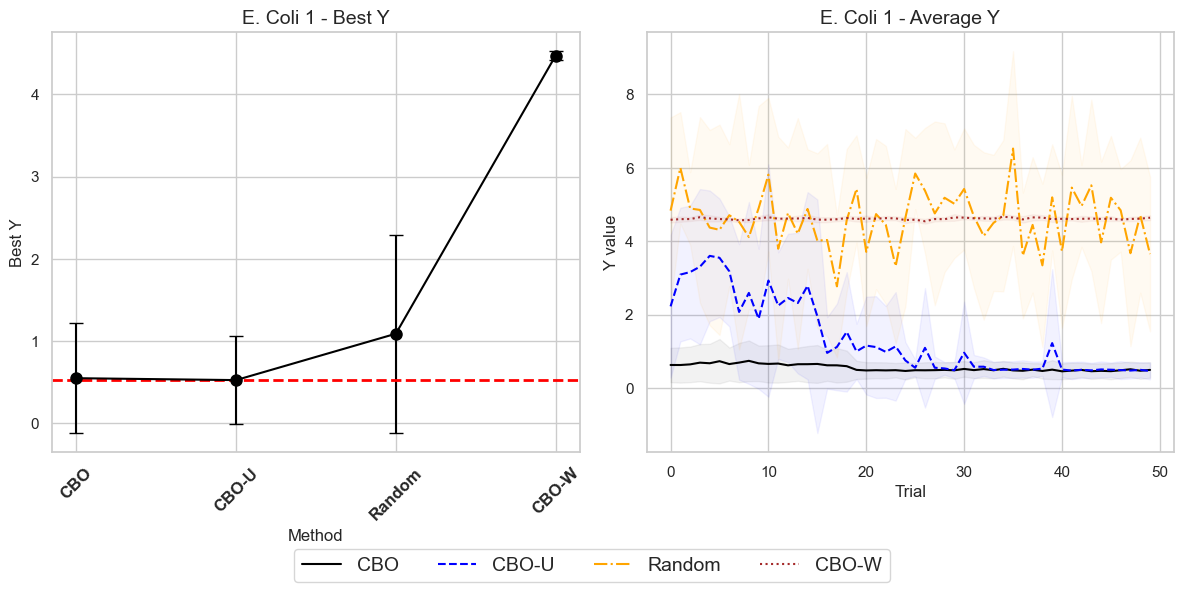

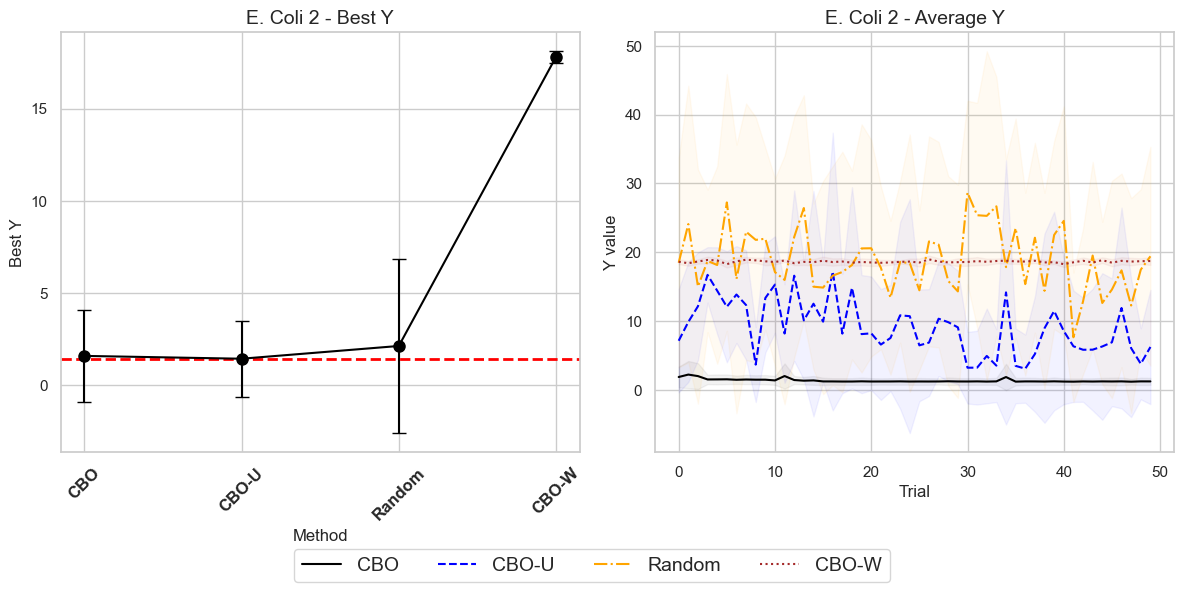

In [13]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

def plot_everything(ax, base_path, experiment, n_obs=200, n_int=1, nonlinear=False,
                    plot_cbo=True, plot_dr2=True, plot_random=True, plot_misspecified=True):
    sns.set_theme(style="whitegrid")
    nonlinear_string = "_nonlinear" if nonlinear else ""
    # Restored original colors and line styles
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    line_styles = {"CBO": "-", "CBO-U": "--", "Random": "-.", "CBO-W": ":"}
    methods = []
    data_results = {}

    if plot_cbo:
        methods.append("CBO")
        # Load results for CBO
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        data_results["CBO"] = cbo_results

    if plot_dr2:
        methods.append("CBO-U")
        # Load results for CBO Unknown
        dr2_string = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        dr2_results = load_results(base_path, dr2_string)
        data_results["CBO-U"] = dr2_results

    if plot_random:
        methods.append("Random")
        # Load results for Random
        random_string = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        data_results["Random"] = random_results

    if plot_misspecified:
        methods.append("CBO-W")
        # Load results for CBO-W (misspecified)
        misspecified_string = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        misspecified_results = load_results(base_path, misspecified_string)
        data_results["CBO-W"] = misspecified_results

    if experiment == "Best_Y":
        # Prepare data for error bar plots
        means = []
        stds = []
        x_positions = np.arange(len(methods))
        for method in methods:
            results = data_results.get(method, [])
            if results:
                best_Y_values = [result["Best_Y"] for result in results]
                best_Y_values_flat = np.concatenate(best_Y_values)
                mean_value = np.mean(best_Y_values_flat)
                std_value = np.std(best_Y_values_flat)
                means.append(mean_value)
                stds.append(std_value)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        # Plot error bars with connected lines in black
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Get the mean value of "CBO Unknown" to plot the horizontal dashed line
        try:
            idx_cbo_unknown = methods.index('CBO-U')
            cbo_unknown_mean = means[idx_cbo_unknown]
        except ValueError:
            cbo_unknown_mean = None  # "CBO Unknown" data not available

        # Plot horizontal dashed line at the "CBO Unknown" mean
        if cbo_unknown_mean is not None and not np.isnan(cbo_unknown_mean):
            ax.axhline(y=cbo_unknown_mean, color='red', linestyle='--', linewidth=2)

        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(methods, rotation=45, fontsize=12, fontweight='bold')

        ax.set_xlabel("Method", fontsize=12)
        ax.set_ylabel("Best Y", fontsize=12)
        ax.grid(True)
    else:
        # For Per_trial_Y, use original colors and line styles
        for method in methods:
            results = data_results.get(method, [])
            if results:
                mean_values, std_values = aggregate_results(results, experiment)
                x_values = range(len(mean_values))
                # Adjust alpha to make standard deviation area lighter
                alpha = 0.05  # Make standard deviation area lighter
                ax.fill_between(
                    x_values,
                    mean_values - std_values,
                    mean_values + std_values,
                    alpha=alpha,
                    color=colors.get(method, 'gray')
                )
                ax.plot(
                    x_values,
                    mean_values,
                    label=method,
                    color=colors.get(method, 'black'),
                    linestyle=line_styles.get(method, '-')
                )

        ax.set_xlabel("Trial", fontsize=12)
        ax.set_ylabel("Y value", fontsize=12)
        ax.grid(True)

    return ax

def summarise_ecoli1_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (error bar plot)
    plot_everything(
        axs[0],
        base_path="Ecoli1",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 1 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli1",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 1 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', ncol=4)
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli1_summary.png", bbox_inches="tight")
    plt.show()

def summarise_ecoli2_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (error bar plot)
    plot_everything(
        axs[0],
        base_path="Ecoli2",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 2 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli2",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 2 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli2_summary.png", bbox_inches="tight")
    plt.show()

# Call the functions to create and save the figures
summarise_ecoli1_results()
summarise_ecoli2_results()


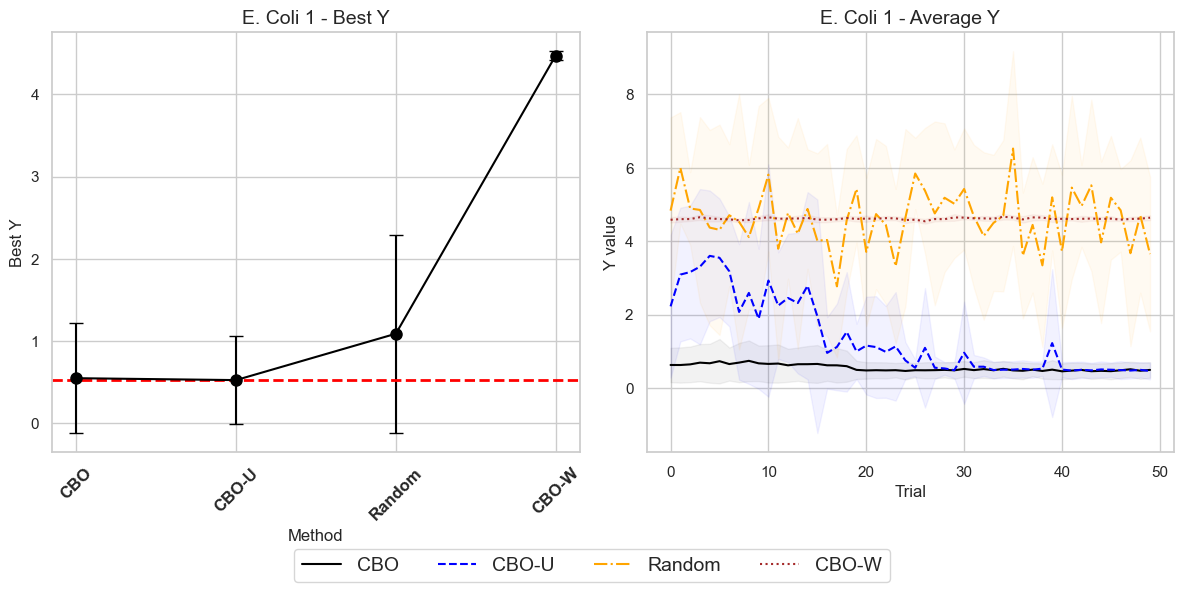

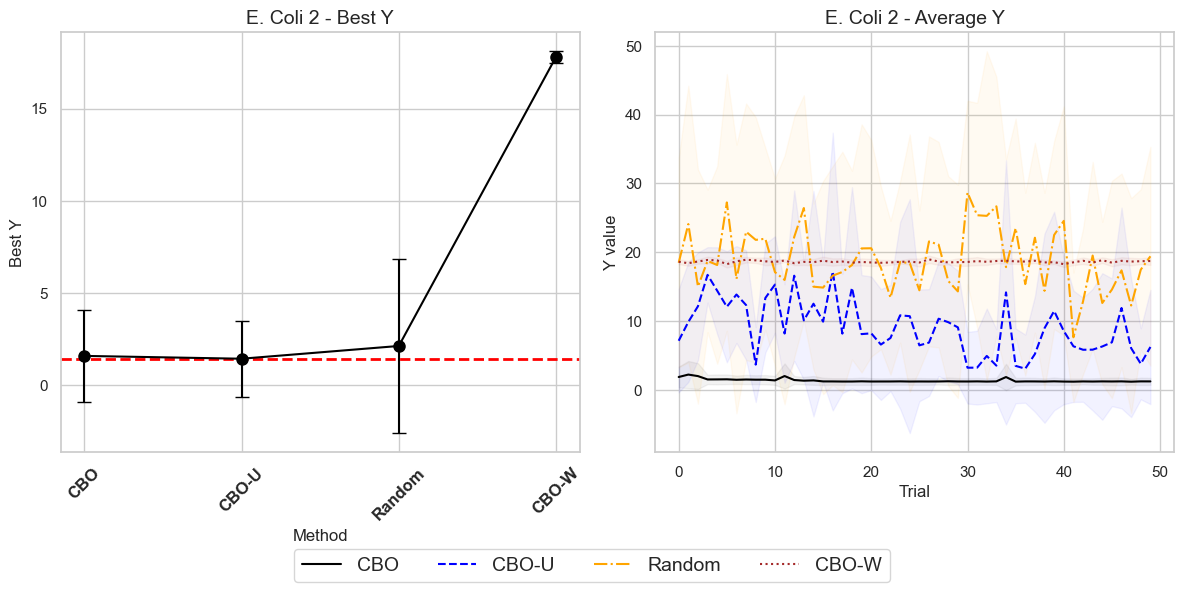

In [14]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

def plot_everything(ax, base_path, experiment, n_obs=200, n_int=1, nonlinear=False,
                    plot_cbo=True, plot_dr2=True, plot_random=True, plot_misspecified=True):
    sns.set_theme(style="whitegrid")
    nonlinear_string = "_nonlinear" if nonlinear else ""
    # Restored original colors and line styles
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    line_styles = {"CBO": "-", "CBO-U": "--", "Random": "-.", "CBO-W": ":"}
    methods = []
    data_results = {}

    if plot_cbo:
        methods.append("CBO")
        # Load results for CBO
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        data_results["CBO"] = cbo_results

    if plot_dr2:
        methods.append("CBO-U")
        # Load results for CBO Unknown
        dr2_string = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        dr2_results = load_results(base_path, dr2_string)
        data_results["CBO-U"] = dr2_results

    if plot_random:
        methods.append("Random")
        # Load results for Random
        random_string = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        data_results["Random"] = random_results

    if plot_misspecified:
        methods.append("CBO-W")
        # Load results for CBO-W (misspecified)
        misspecified_string = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        misspecified_results = load_results(base_path, misspecified_string)
        data_results["CBO-W"] = misspecified_results

    if experiment == "Best_Y":
        # Prepare data for error bar plots
        means = []
        stds = []
        x_positions = np.arange(len(methods))
        for method in methods:
            results = data_results.get(method, [])
            if results:
                best_Y_values = [result["Best_Y"] for result in results]
                best_Y_values_flat = np.concatenate(best_Y_values)
                mean_value = np.mean(best_Y_values_flat)
                std_value = np.std(best_Y_values_flat)
                means.append(mean_value)
                stds.append(std_value)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        # Plot error bars with connected lines in black
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Get the mean value of "CBO Unknown" to plot the horizontal dashed line
        try:
            idx_cbo_unknown = methods.index('CBO-U')
            cbo_unknown_mean = means[idx_cbo_unknown]
        except ValueError:
            cbo_unknown_mean = None  # "CBO Unknown" data not available

        # Plot horizontal dashed line at the "CBO Unknown" mean
        if cbo_unknown_mean is not None and not np.isnan(cbo_unknown_mean):
            ax.axhline(y=cbo_unknown_mean, color='red', linestyle='--', linewidth=2)

        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(methods, rotation=45, fontsize=12, fontweight='bold')

        ax.set_xlabel("Method", fontsize=12)
        ax.set_ylabel("Best Y", fontsize=12)
        ax.grid(True)
    else:
        # For Per_trial_Y, use original colors and line styles
        for method in methods:
            results = data_results.get(method, [])
            if results:
                mean_values, std_values = aggregate_results(results, experiment)
                x_values = range(len(mean_values))
                # Adjust alpha to make standard deviation area lighter
                alpha = 0.05  # Make standard deviation area lighter
                ax.fill_between(
                    x_values,
                    mean_values - std_values,
                    mean_values + std_values,
                    alpha=alpha,
                    color=colors.get(method, 'gray')
                )
                ax.plot(
                    x_values,
                    mean_values,
                    label=method,
                    color=colors.get(method, 'black'),
                    linestyle=line_styles.get(method, '-')
                )

        ax.set_xlabel("Trial", fontsize=12)
        ax.set_ylabel("Y value", fontsize=12)
        ax.grid(True)

    return ax

def summarise_ecoli1_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (error bar plot)
    plot_everything(
        axs[0],
        base_path="Ecoli1",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 1 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli1",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 1 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', ncol=4)
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli1_summary.png", bbox_inches="tight")
    plt.show()

def summarise_ecoli2_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (error bar plot)
    plot_everything(
        axs[0],
        base_path="Ecoli2",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 2 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli2",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 2 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli2_summary.png", bbox_inches="tight")
    plt.show()

# Call the functions to create and save the figures
summarise_ecoli1_results()
summarise_ecoli2_results()


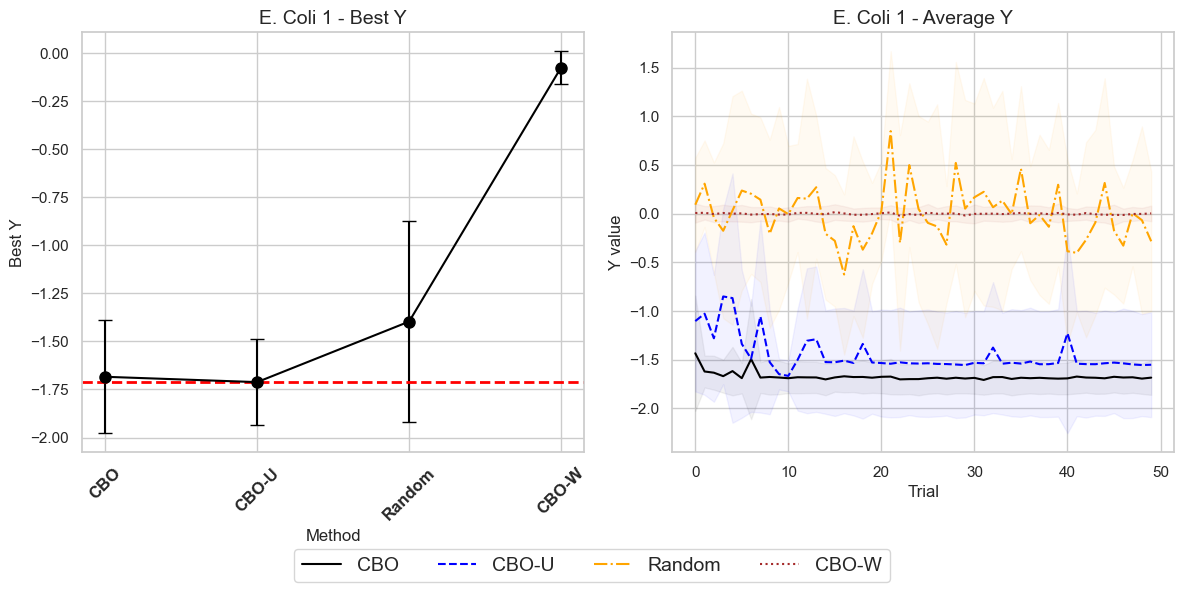

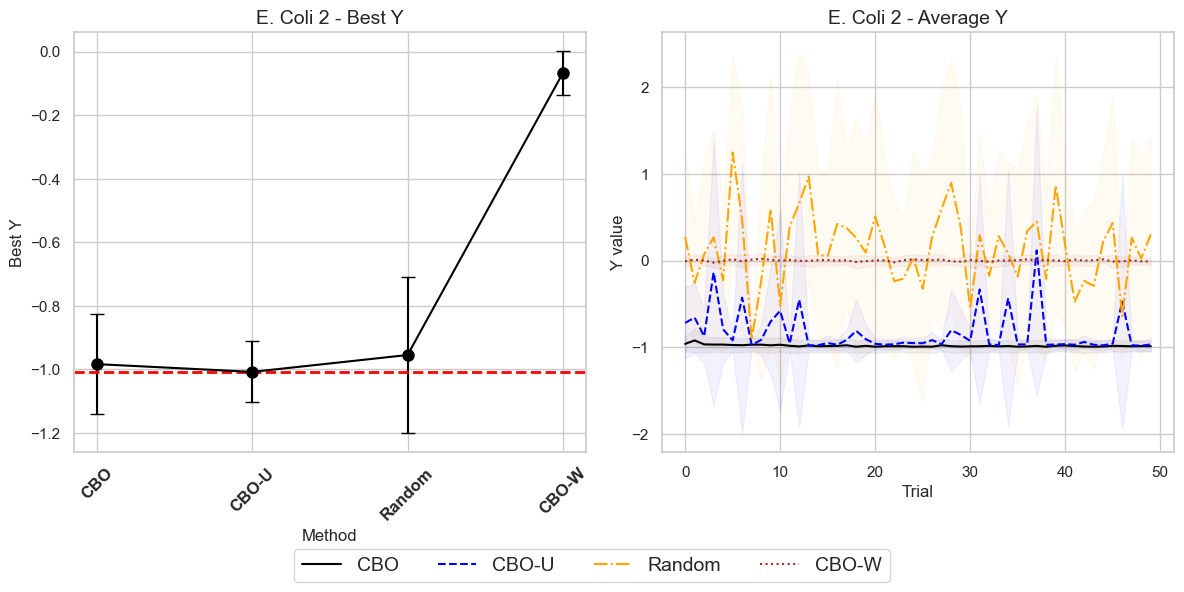

In [15]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

def plot_everything(ax, base_path, experiment, n_obs=200, n_int=1, nonlinear=False,
                    plot_cbo=True, plot_dr2=True, plot_random=True, plot_misspecified=True):
    sns.set_theme(style="whitegrid")
    nonlinear_string = "_nonlinear" if nonlinear else ""
    # Restored original colors and line styles
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    line_styles = {"CBO": "-", "CBO-U": "--", "Random": "-.", "CBO-W": ":"}
    methods = []
    data_results = {}

    if plot_cbo:
        methods.append("CBO")
        # Load results for CBO
        cbo_string = rf".*_cbo_results_iscm_{n_obs}_{n_int}{nonlinear_string}.pickle"
        cbo_results = load_results(base_path, cbo_string)
        data_results["CBO"] = cbo_results

    if plot_dr2:
        methods.append("CBO-U")
        # Load results for CBO Unknown
        dr2_string = rf".*_cbo_unknown_dr2_iscm_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        dr2_results = load_results(base_path, dr2_string)
        data_results["CBO-U"] = dr2_results

    if plot_random:
        methods.append("Random")
        # Load results for Random
        random_string = rf".*_cbo_results_random_iscm_{n_obs}_{n_int}{nonlinear_string}.pickle"
        random_results = load_results(base_path, random_string)
        data_results["Random"] = random_results

    if plot_misspecified:
        methods.append("CBO-W")
        # Load results for CBO-W (misspecified)
        misspecified_string = rf".*_cbo_misspecified_results_iscm_{n_obs}_{n_int}{nonlinear_string}.pickle"
        misspecified_results = load_results(base_path, misspecified_string)
        data_results["CBO-W"] = misspecified_results

    if experiment == "Best_Y":
        # Prepare data for error bar plots
        means = []
        stds = []
        x_positions = np.arange(len(methods))
        for method in methods:
            results = data_results.get(method, [])
            if results:
                best_Y_values = [result["Best_Y"] for result in results]
                best_Y_values_flat = np.concatenate(best_Y_values)
                mean_value = np.mean(best_Y_values_flat)
                std_value = np.std(best_Y_values_flat)
                means.append(mean_value)
                stds.append(std_value)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        # Plot error bars with connected lines in black
        ax.errorbar(
            x_positions, means, yerr=stds, fmt='o-', color='black', ecolor='black',
            capsize=5, markersize=8
        )

        # Get the mean value of "CBO Unknown" to plot the horizontal dashed line
        try:
            idx_cbo_unknown = methods.index('CBO-U')
            cbo_unknown_mean = means[idx_cbo_unknown]
        except ValueError:
            cbo_unknown_mean = None  # "CBO Unknown" data not available

        # Plot horizontal dashed line at the "CBO Unknown" mean
        if cbo_unknown_mean is not None and not np.isnan(cbo_unknown_mean):
            ax.axhline(y=cbo_unknown_mean, color='red', linestyle='--', linewidth=2)

        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(methods, rotation=45, fontsize=12, fontweight='bold')

        ax.set_xlabel("Method", fontsize=12)
        ax.set_ylabel("Best Y", fontsize=12)
        ax.grid(True)
    else:
        # For Per_trial_Y, use original colors and line styles
        for method in methods:
            results = data_results.get(method, [])
            if results:
                mean_values, std_values = aggregate_results(results, experiment)
                x_values = range(len(mean_values))
                # Adjust alpha to make standard deviation area lighter
                alpha = 0.05  # Make standard deviation area lighter
                ax.fill_between(
                    x_values,
                    mean_values - std_values,
                    mean_values + std_values,
                    alpha=alpha,
                    color=colors.get(method, 'gray')
                )
                ax.plot(
                    x_values,
                    mean_values,
                    label=method,
                    color=colors.get(method, 'black'),
                    linestyle=line_styles.get(method, '-')
                )

        ax.set_xlabel("Trial", fontsize=12)
        ax.set_ylabel("Y value", fontsize=12)
        ax.grid(True)

    return ax

def summarise_ecoli1_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (error bar plot)
    plot_everything(
        axs[0],
        base_path="Ecoli1",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 1 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli1",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 1 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', ncol=4)
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli1_summary_iscm.png", bbox_inches="tight")
    plt.show()

def summarise_ecoli2_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns

    # Left plot: Best Y (error bar plot)
    plot_everything(
        axs[0],
        base_path="Ecoli2",
        experiment="Best_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[0].set_title("E. Coli 2 - Best Y", fontsize=14)

    # Right plot: Average Y (line plot)
    plot_everything(
        axs[1],
        base_path="Ecoli2",
        experiment="Per_trial_Y",
        n_obs=200,
        n_int=1,
        plot_cbo=True,
        plot_dr2=True,
        plot_random=True,
        plot_misspecified=True
    )
    axs[1].set_title("E. Coli 2 - Average Y", fontsize=14)

    # Single legend for both plots
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for legend
    plt.savefig("ecoli2_summary_iscm.png", bbox_inches="tight")
    plt.show()

# Call the functions to create and save the figures
summarise_ecoli1_results()
summarise_ecoli2_results()


# Ablation study

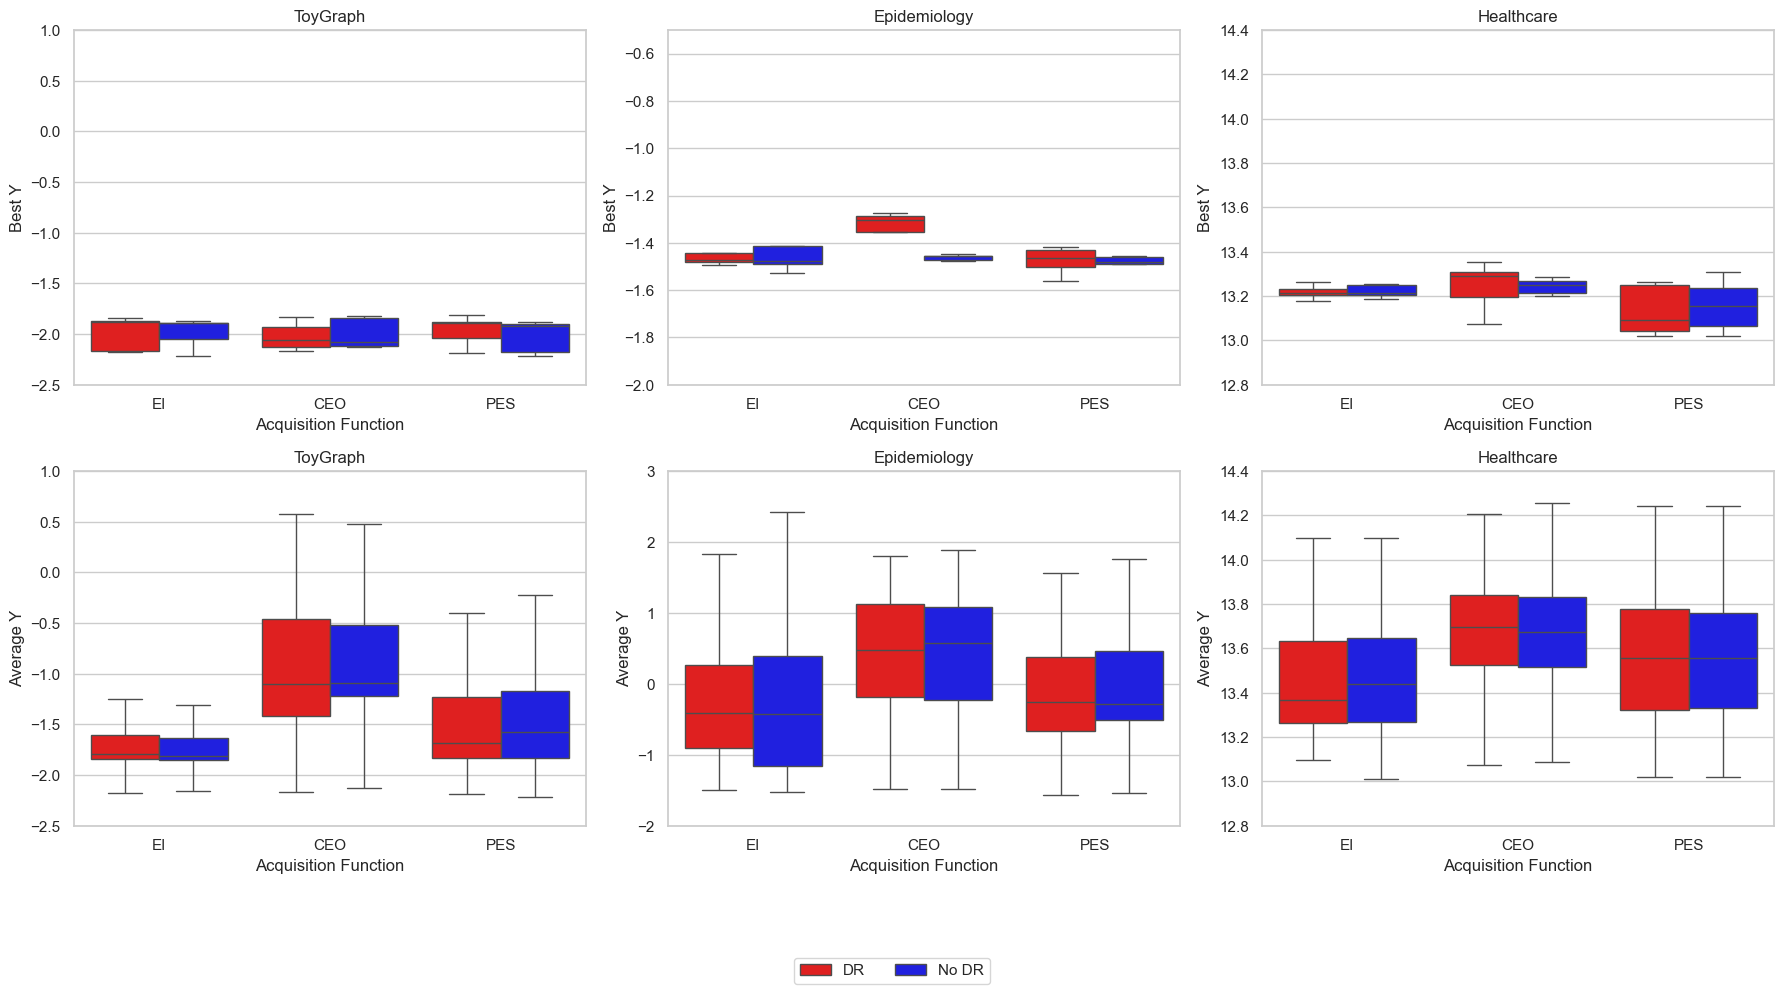

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List

# Assuming load_results function is defined elsewhere
def plot_acquisitions_all_boxplot(
    graphs: List = ["ToyGraphUnknown", "Graph5Unknown", "Graph6Unknown"],
    n_obs: int = 200,
    acquisition_list: List = ["EI", "CEO", "PES"],
    use_dr_list: List[bool] = [True, False],
    save_file: bool = False,
):
    sns.set_theme(style="whitegrid")  # Use seaborn style for better aesthetics

    # Define colors for DR (red) and No DR (blue)
    colors = ["red", "blue"]

    # Map graph names to titles
    title_map = {
        "ToyGraphUnknown": "ToyGraph",
        "Graph5Unknown": "Epidemiology",
        "Graph6Unknown": "Healthcare"
    }

    # Create a figure with 2 rows and len(graphs) columns (1 for each graph)
    fig, axs = plt.subplots(2, len(graphs), figsize=(18, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for col_idx, graph in enumerate(graphs):
        for row_idx, metric in enumerate(["Best_Y", "Per_trial_Y"]):
            ax = axs[row_idx, col_idx]

            plot_data = {"Acquisition": [], "Value": [], "Type": []}

            for use_dr, color in zip(use_dr_list, colors):
                for acquisition in acquisition_list:
                    dr_string = "_dr" if use_dr else "_all"
                    experiment_pattern = (
                        rf".*_cbo{dr_string}_{acquisition}_results_{n_obs}"
                    )
                    all_results = load_results(
                        base_path=f"{graph}", regex=experiment_pattern
                    )

                    if metric == "Best_Y":
                        res = np.vstack([result[metric][:30] for result in all_results])
                        res = res.min(axis=1)
                    else:
                        res = np.hstack([result[metric][:30] for result in all_results])

                    # Add data to plot_data dictionary
                    plot_data["Acquisition"].extend([acquisition] * len(res))
                    plot_data["Value"].extend(res)
                    plot_data["Type"].extend(["DR" if use_dr else "No DR"] * len(res))

            # Create boxplots
            sns.boxplot(
                ax=ax,
                x="Acquisition",
                y="Value",
                hue="Type",
                data=plot_data,
                showfliers=False,
                palette=colors,
            )

            # Remove the legend for individual plots
            ax.get_legend().remove()

            # Set title and labels
            ax.set_title(f"{title_map.get(graph, graph)}")
            ax.set_ylabel("Best Y" if row_idx == 0 else "Average Y")
            ax.set_xlabel("Acquisition Function")
            # ax.margins(y=0.4)

            # Set specific y-axis limits for each graph
            if graph == "ToyGraphUnknown":
                ax.set_ylim(-2.5, 1)
            elif graph == "Graph5Unknown" and row_idx == 0:
                ax.set_ylim(-2, -0.5)
            elif graph == "Graph5Unknown" and row_idx == 1:
                ax.set_ylim(-2, 3)
            elif graph == "Graph6Unknown":
                ax.set_ylim(12.8, 14.4)

    # Add a single legend at the bottom
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        ncol=len(use_dr_list),
    )

    # Adjust layout for better visualization
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the legend

    # if save_file:
    plt.savefig("acquisition_comparison.png", bbox_inches="tight")

    plt.show()

plot_acquisitions_all_boxplot()

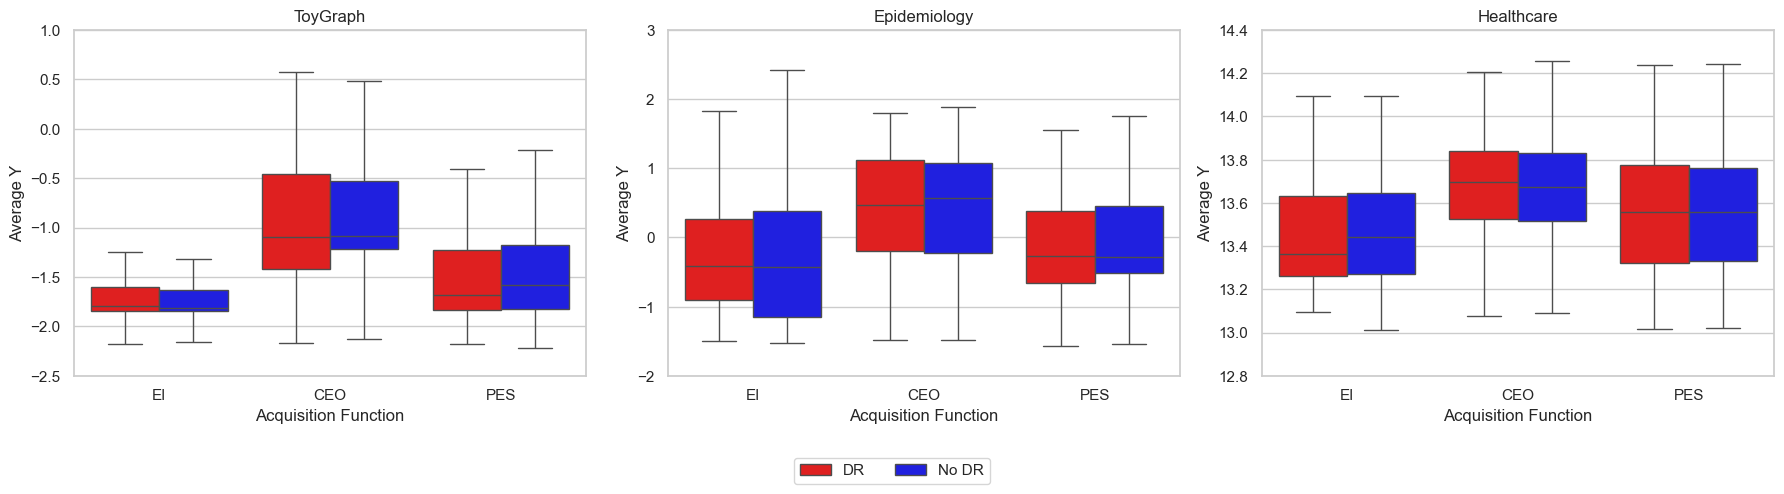

In [11]:
# Assuming load_results function is defined elsewhere
def plot_acquisitions_average_y_boxplot(
    graphs: List = ["ToyGraphUnknown", "Graph5Unknown", "Graph6Unknown"],
    n_obs: int = 200,
    acquisition_list: List = ["EI", "CEO", "PES"],
    use_dr_list: List[bool] = [True, False],
    save_file: bool = False,
):
    sns.set_theme(style="whitegrid")  # Use seaborn style for better aesthetics

    # Define colors for DR (red) and No DR (blue)
    colors = ["red", "blue"]

    # Map graph names to titles
    title_map = {
        "ToyGraphUnknown": "ToyGraph",
        "Graph5Unknown": "Epidemiology",
        "Graph6Unknown": "Healthcare"
    }

    # Create a figure with 1 row and len(graphs) columns (1 for each graph)
    fig, axs = plt.subplots(1, len(graphs), figsize=(18, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for col_idx, graph in enumerate(graphs):
        ax = axs[col_idx]

        plot_data = {"Acquisition": [], "Value": [], "Type": []}

        for use_dr, color in zip(use_dr_list, colors):
            for acquisition in acquisition_list:
                dr_string = "_dr" if use_dr else "_all"
                experiment_pattern = (
                    rf".*_cbo{dr_string}_{acquisition}_results_{n_obs}"
                )
                all_results = load_results(
                    base_path=f"{graph}", regex=experiment_pattern
                )

                # Use "Per_trial_Y" metric
                res = np.hstack([result["Best_Y"][:30] for result in all_results])

                # Add data to plot_data dictionary
                plot_data["Acquisition"].extend([acquisition] * len(res))
                plot_data["Value"].extend(res)
                plot_data["Type"].extend(["DR" if use_dr else "No DR"] * len(res))

        # Create boxplots
        sns.boxplot(
            ax=ax,
            x="Acquisition",
            y="Value",
            hue="Type",
            data=plot_data,
            showfliers=False,
            palette=colors,
        )

        # Remove the legend for individual plots
        ax.get_legend().remove()

        # Set title and labels
        ax.set_title(f"{title_map.get(graph, graph)}")
        ax.set_ylabel("Average Y")
        ax.set_xlabel("Acquisition Function")

        # Set specific y-axis limits for each graph
        if graph == "ToyGraphUnknown":
            ax.set_ylim(-2.5, 1)
        elif graph == "Graph5Unknown":
            ax.set_ylim(-2, 3)
        elif graph == "Graph6Unknown":
            ax.set_ylim(12.8, 14.4)

    # Add a single legend at the bottom
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        ncol=len(use_dr_list),
    )

    # Adjust layout for better visualization
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the legend

    # Save the figure if needed
    # if save_file: 
    plt.savefig("acquisition_comparison.png", bbox_inches="tight")

    plt.show()

plot_acquisitions_average_y_boxplot()

# Direct parent experiment

/tmp/ipykernel_3337828/2338616217.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  inferno = cm.get_cmap("plasma")


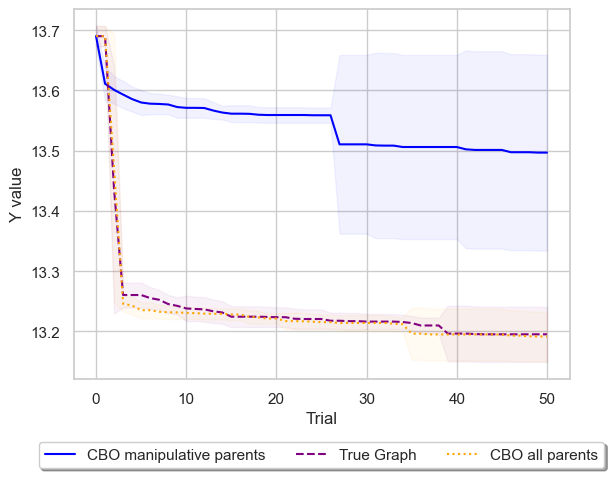

In [17]:
import matplotlib.cm as cm
def plot_everything(
    base_path,
    experiment,
    num_cbo_graphs,
    n_obs=200,
    n_int=2,
    noiseless=True,
    save_file=False,
    plot_ceo=False,
    plot_cbo=True,
    plot_bo=True,
    plot_cbo_unknown=False,
    plot_cbo_parents=True,
    graph_idxs=None,
):
    inferno = cm.get_cmap("plasma")
    colors = inferno(np.linspace(0, 1, num_cbo_graphs + 3))
    colors = [
        "Black",  # Teal
        "Blue",  # Replacing Red with Blue
        "Purple",  # Replacing Yellow with Purple
        "Orange",  # Replacing Brown with Orange
        "#666666",  # Gray
        "#8c564b",  # Brownish Red
        "Blue",  # Replacing Orange
        "Purple",  # Replacing Blue
        "Orange",  # Replacing Green
    ]
    
    # Line styles
    line_styles = ['-', '--', '-.', ':']  # Solid, dashed, dash-dot, dotted

    if graph_idxs is None:
        graph_idxs = range(num_cbo_graphs)
    noisy_suffix = r"\.pickle" if noiseless else r"noisy\.pickle"
    noisy_string = "" if noiseless else "_noisy"

    # Load and aggregate results for CEO
    ceo_string = rf".*_ceo_.*_results_{n_obs}_{n_int}_{noisy_suffix}"
    ceo_results = load_results(base_path, ceo_string)
    ceo_mean, ceo_std = aggregate_results(ceo_results, experiment)

    # Load and aggregate results for BO
    bo_string = rf".*_bo_results_{n_obs}_{n_int}_{noisy_suffix}"
    bo_results = load_results(base_path, bo_string)
    bo_mean, bo_std = aggregate_results(bo_results, experiment)

    if plot_bo:
        x_values = range(len(bo_mean))
        plt.fill_between(
            x_values, bo_mean - bo_std, bo_mean + bo_std, alpha=0.05, color=colors[1]
        )
        plt.plot(
            x_values, 
            bo_mean, 
            label="CBO manipulative parents", 
            color=colors[1],
            linestyle=line_styles[0]  # Solid line
        )

    if plot_cbo:
        for graph_index in range(num_cbo_graphs):
            cbo_string = rf".*_cbo_results_{n_obs}_{n_int}_graph_{graph_index}{noisy_suffix}"
            cbo_results = load_results(base_path, cbo_string)
            cbo_mean, cbo_std = aggregate_results(cbo_results, experiment)

            if graph_index in graph_idxs:
                x_values = range(len(cbo_mean))
                plt.fill_between(
                    x_values,
                    cbo_mean - cbo_std,
                    cbo_mean + cbo_std,
                    alpha=0.05,
                    color=colors[graph_index + 2],
                )
                label = "True Graph" if graph_index == 0 else f"CBO Graph {graph_index}"
                plt.plot(
                    x_values,
                    cbo_mean,
                    label=label,
                    color=colors[graph_index + 2],
                    linestyle=line_styles[(graph_index + 1) % len(line_styles)]  # Rotate line styles
                )

    if plot_cbo_parents:
        cbo_string = rf".*_cbo_results_{n_obs}_{n_int}_graph_0{noisy_suffix}"
        cbo_results = load_results(f"{base_path}_blanket", cbo_string)
        cbo_mean, cbo_std = aggregate_results(cbo_results, experiment)
        x_values = range(len(cbo_mean))
        plt.fill_between(
            x_values,
            cbo_mean - cbo_std,
            cbo_mean + cbo_std,
            alpha=0.05,
            color=colors[-1],
        )
        plt.plot(
            x_values, 
            cbo_mean, 
            label=f"CBO all parents", 
            color=colors[-1],
            linestyle=line_styles[-1]  # Last line style
        )

    # Final plot adjustments
    plt.xlabel("Trial")
    plt.ylabel("Y value")
    plt.grid(True)
    
    # Move the legend to the bottom
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

    if save_file:
        filename = f"Parent_test"
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

# os.chdir("/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt/results")
plot_everything(base_path="Graph6", experiment="Best_Y", num_cbo_graphs=5, graph_idxs=[0], save_file=True)

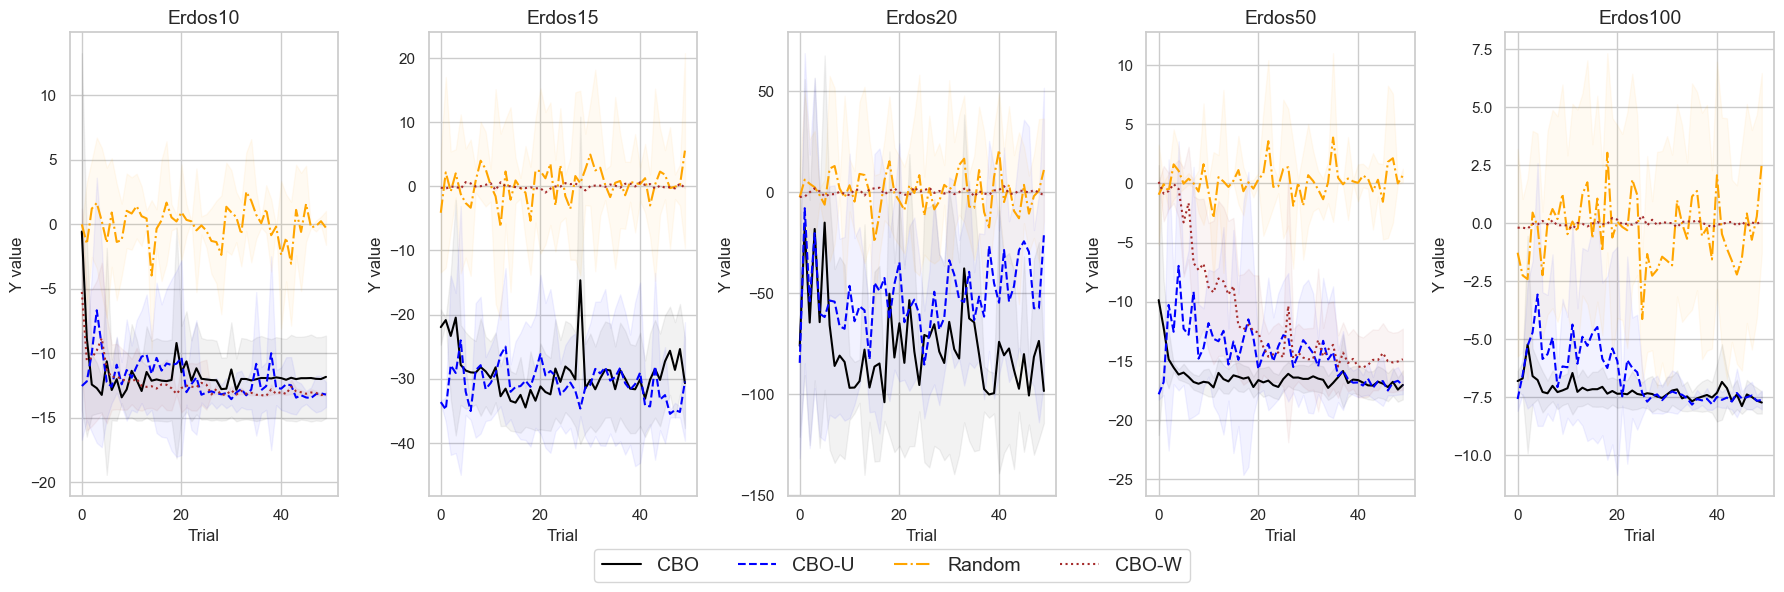

In [12]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to aggregate results
def aggregate_results(results, experiment):
    """
    Aggregates the results for plotting.

    Args:
        results: List of result dictionaries.
        experiment: String, either "Best_Y" or "Per_trial_Y"

    Returns:
        mean_values: Array of mean values over trials.
        std_values: Array of standard deviations over trials.
    """
    all_values = [result[experiment] for result in results]
    all_values = np.array(all_values)
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

# Function to plot Per_trial_Y for a given dataset
def plot_per_trial_y(ax, base_path, methods, colors, line_styles):
    if base_path != "Erdos100_2":
        n_obs = 200
    else:
        n_obs = 700
    n_int = 2
    nonlinear = False  # Set nonlinear to True as per your request
    experiment = "Per_trial_Y"
    nonlinear_string = "_nonlinear" if nonlinear else ""

    for method in methods:
        if method == "CBO":
            pattern = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-U":
            pattern = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "Random":
            pattern = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-W":
            pattern = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        # Load results matching pattern
        results = load_results(base_path, pattern)
        if results:
            mean_values, std_values = aggregate_results(results, experiment)
            x_values = range(len(mean_values))
            # Fade the standard deviation shading further by reducing alpha
            ax.fill_between(
                x_values,
                mean_values - std_values,
                mean_values + std_values,
                alpha=0.05,  # Reduced alpha to make shading more transparent
                color=colors.get(method, 'gray')
            )
            ax.plot(
                x_values,
                mean_values,
                label=method,
                color=colors.get(method, 'black'),
                linestyle=line_styles.get(method, '-')
            )
    ax.set_xlabel("Trial")
    ax.set_ylabel("Y value")
    ax.grid(True)
    # Remove individual legends
    # ax.legend(fontsize=10)

# Function to plot the results for Erdos datasets
def plot_erdos_results():
    sns.set_theme(style="whitegrid")
    base_paths = ["Erdos10", "Erdos15", "Erdos20", "Erdos50", "Erdos100_2"]
    methods = ["CBO", "CBO-U", "Random", "CBO-W"]
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    line_styles = {"CBO": "-", "CBO-U": "--", "Random": "-.", "CBO-W": ":"}
    fig, axs = plt.subplots(1, 5, figsize=(18, 6))  # Adjusted figure size

    for i, base_path in enumerate(base_paths):
        ax = axs[i]
        plot_per_trial_y(ax, base_path, methods, colors, line_styles)
        if base_path == "Erdos100_2":
            ax.set_title("Erdos100", fontsize=14)
        else:
            ax.set_title(base_path, fontsize=14)

    # Place the legend at the bottom with font size 14
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig("per_trial_results_erdos_linear.png")
    plt.show()

# Call the function to generate the plots
plot_erdos_results()


# Percentage of targeted interventions

In [19]:
import pickle

def proportion_correct():
    os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/results/Erdos10/")
    with open("run4_cbo_unknown_dr2_results_200_2_nonlinear.pickle", "rb") as file:
        results = pickle.load(file)


    # Initialize a counter
    count = 0

    # Iterate through the list of tuples and check for '2' or '9'
    for tup in results['Intervention_Set']:
        if '2' in tup or '9' in tup:
            count += 1

    # Output the count
    print(f"The number of tuples containing '2' or '9' is: {count}")

proportion_correct()

The number of tuples containing '2' or '9' is: 44


500
500
500
500
500
500
500
500
500
500
500
500
500


300
500
500


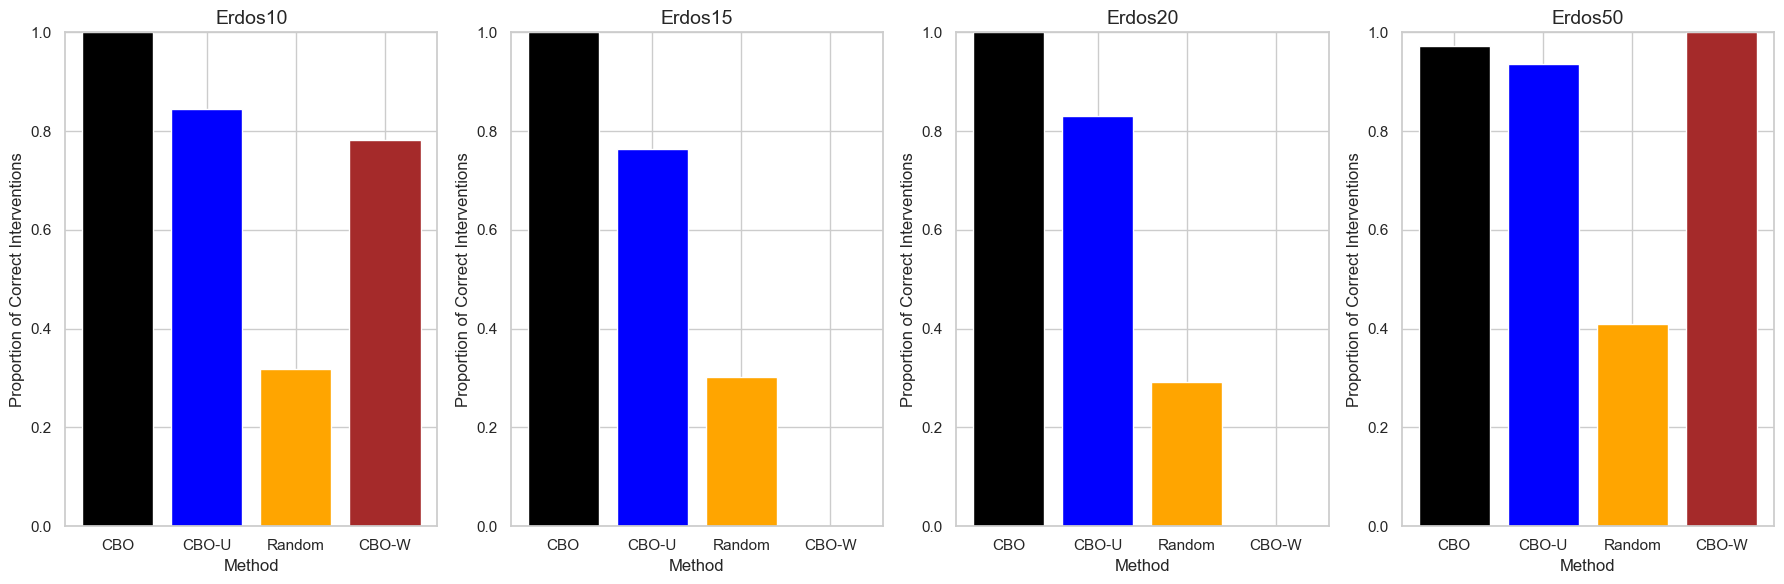

In [20]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to calculate proportions for a given dataset
def calculate_proportions(base_path, methods):
    n_obs = 200
    n_int = 2
    nonlinear = True  # Set nonlinear to True as per your request
    nonlinear_string = "_nonlinear" if nonlinear else ""

    proportions = {}  # To store proportions for each method
    for method in methods:
        if method == "CBO":
            pattern = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-U":
            pattern = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "Random":
            pattern = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-W":
            pattern = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        # Load results matching pattern
        results = load_results(base_path, pattern)
        count = 0
        total = 0
        if results:
            intervention_sets = list(chain.from_iterable(result["Intervention_Set"] for result in results))
            print(len(intervention_sets))
            for intervention_set in intervention_sets:
                total += 1
                for tup in intervention_set:
                    # Modify conditions based on the dataset
                    if base_path == "Erdos10":
                        if '2' in tup or '9' in tup:
                            count += 1
                            break  # Count once per intervention_set
                    elif base_path == "Erdos15":
                        if '4' in tup or '11' in tup:
                            count += 1
                            break
                    elif base_path == "Erdos20":
                        if '4' in tup:
                            count += 1
                            break
                    elif base_path == "Erdos50":
                        if '4' in tup or '11' in tup:
                            count += 1
                            break
            if total > 0:
                proportion = count / total
            else:
                proportion = 0
            proportions[method] = proportion
        else:
            proportions[method] = 0
    return proportions

# Function to plot the results for Erdos datasets
def plot_erdos_results():
    sns.set_theme(style="whitegrid")
    base_paths = ["Erdos10", "Erdos15", "Erdos20", "Erdos50"]
    methods = ["CBO", "CBO-U", "Random", "CBO-W"]
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))

    for i, base_path in enumerate(base_paths):
        ax = axs[i]
        proportions = calculate_proportions(base_path, methods)
        method_names = list(proportions.keys())
        proportion_values = [proportions[method] for method in method_names]
        ax.bar(method_names, proportion_values, color=[colors[method] for method in method_names])
        ax.set_title(base_path, fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Proportion of Correct Interventions")
        ax.set_xlabel("Method")
        ax.grid(True)

    # Adjust layout to make space for the plots
    plt.tight_layout()
    plt.savefig("proportion_correctly_selected_interventions_barplot.png")
    plt.show()

# Call the function to generate the plots
os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/results/")
plot_erdos_results()


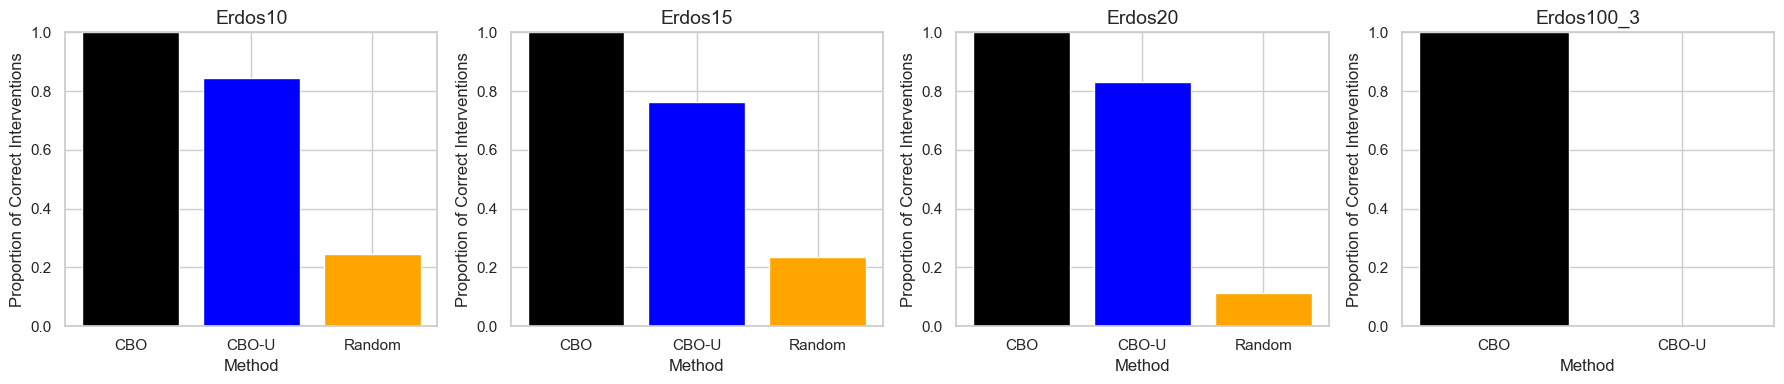

In [25]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to calculate proportions for a given dataset
def calculate_proportions(base_path, methods):
    if base_path != "Erdos100_3":
        n_obs = 200
    else:
        n_obs = 500
    n_int = 2
    nonlinear = True  # Set nonlinear to True as per your request
    nonlinear_string = "_nonlinear" if nonlinear else ""

    proportions = {}  # To store proportions for each method
    for method in methods:
        if method == "CBO":
            pattern = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-U":
            pattern = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "Random":
            pattern = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-W":
            pattern = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        # Load results matching pattern
        results = load_results(base_path, pattern)
        count = 0
        total = 0
        if results:
            intervention_sets = list(chain.from_iterable(result["Intervention_Set"] for result in results))
            for intervention_set in intervention_sets:
                total += 1
                for tup in intervention_set:
                    # Modify conditions based on the dataset
                    if base_path == "Erdos10":
                        if '2' in tup or '9' in tup:
                            count += 1
                            break  # Count once per intervention_set
                    elif base_path == "Erdos15":
                        if '4' in tup or '11' in tup:
                            count += 1
                            break
                    elif base_path == "Erdos20":
                        if '4' in tup:
                            count += 1
                            break
                    elif base_path == "Erdos50":
                        if '4' in tup or '11' in tup:
                            count += 1
                            break
            if total > 0:
                proportion = count / total
            
            
            if method == "Random":
                if base_path == "Erdos10":
                    proportions[method] = proportion
                elif base_path == "Erdos15":
                    proportions[method]  = proportion
                elif base_path == "Erdos20":
                    proportions[method] = proportion
                elif base_path == "Erdos50":
                    proportions[method] = 2/50
            elif method == "CBO":
                proportions[method] = 1
            else:
                proportions[method] = proportion
        else:
            proportions[method] = 0
    return proportions

# Function to plot the results for Erdos datasets
def plot_erdos_results():
    sns.set_theme(style="whitegrid")
    base_paths = ["Erdos10", "Erdos15", "Erdos20", "Erdos100_3"]
    methods = ["CBO", "CBO-U", "Random"]
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    for i, base_path in enumerate(base_paths):
        ax = axs[i]
        proportions = calculate_proportions(base_path, methods)
        method_names = list(proportions.keys())
        proportion_values = [proportions[method] for method in method_names]
        ax.bar(method_names, proportion_values, color=[colors[method] for method in method_names])
        ax.set_title(base_path, fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Proportion of Correct Interventions")
        ax.set_xlabel("Method")
        ax.grid(True)

    # Adjust layout to make space for the plots
    plt.tight_layout()
    plt.savefig("proportion_correctly_selected_nonlinear.png")
    plt.show()

# Call the function to generate the plots
os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/results/")
plot_erdos_results()


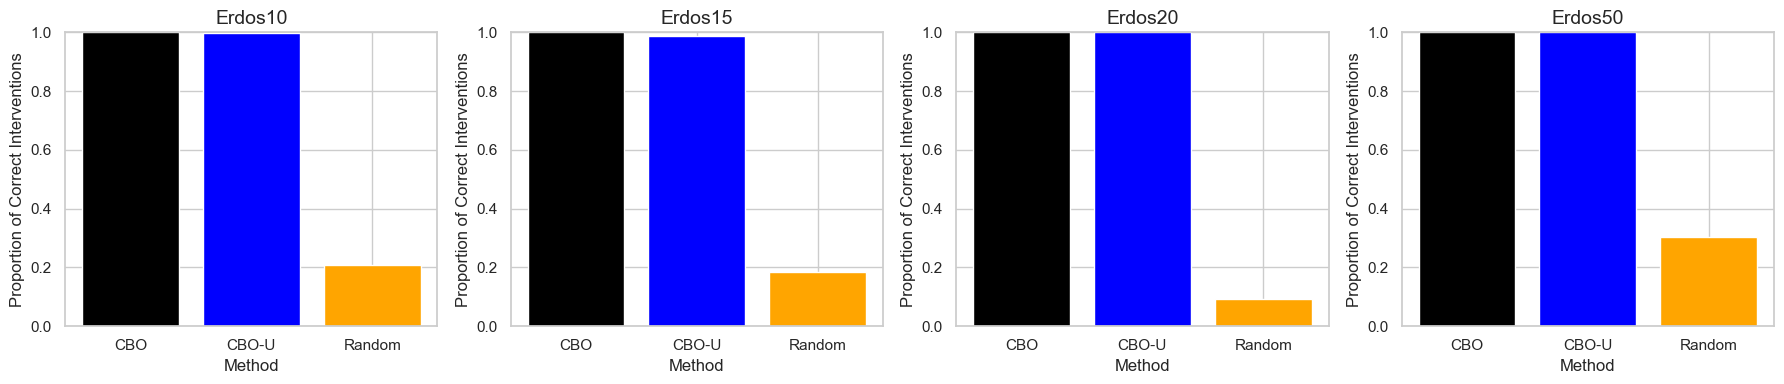

In [14]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

# Function to load all results of a given type
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if re.match(regex, filename):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results

# Function to calculate proportions for a given dataset
def calculate_proportions(base_path, methods):
    n_obs = 200
    n_int = 2
    nonlinear = False  # Set nonlinear to True as per your request
    nonlinear_string = "_nonlinear" if nonlinear else ""

    proportions = {}  # To store proportions for each method
    for method in methods:
        if method == "CBO":
            pattern = rf".*_cbo_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-U":
            pattern = rf".*_cbo_unknown_dr2_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "Random":
            pattern = rf".*_cbo_results_random_{n_obs}_{n_int}{nonlinear_string}.pickle"
        elif method == "CBO-W":
            pattern = rf".*_cbo_misspecified_results_{n_obs}_{n_int}{nonlinear_string}.pickle"
        else:
            continue

        # Load results matching pattern
        results = load_results(base_path, pattern)
        count = 0
        total = 0
        if results:
            intervention_sets = list(chain.from_iterable(result["Intervention_Set"] for result in results))
            for intervention_set in intervention_sets:
                total += 1
                for tup in intervention_set:
                    # Modify conditions based on the dataset
                    if base_path == "Erdos10":
                        if '2' in tup or '9' in tup:
                            count += 1
                            break  # Count once per intervention_set
                    elif base_path == "Erdos15":
                        if '4' in tup or '11' in tup:
                            count += 1
                            break
                    elif base_path == "Erdos20":
                        if '4' in tup:
                            count += 1
                            break
                    elif base_path == "Erdos50":
                        if '4' in tup or '11' in tup:
                            count += 1
                            break
            if total > 0:
                proportion = count / total
            
            # if method == "Random":
            #     if base_path == "Erdos10":
            #         proportions[method] = 2/10
            #     elif base_path == "Erdos15":
            #         proportions[method]  = 2/15
            #     elif base_path == "Erdos20":
            #         proportions[method] = 1/20
            #     elif base_path == "Erdos50":
            #         proportions[method] = 2/50
            # else:
            if method == "CBO":
                proportions[method] = 1
            else:
                proportions[method] = proportion
        else:
            proportions[method] = 0
    return proportions

# Function to plot the results for Erdos datasets
def plot_erdos_results():
    sns.set_theme(style="whitegrid")
    base_paths = ["Erdos10", "Erdos15", "Erdos20", "Erdos50"]
    methods = ["CBO", "CBO-U", "Random"]
    colors = {"CBO": "black", "CBO-U": "blue", "Random": "orange", "CBO-W": "brown"}
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    for i, base_path in enumerate(base_paths):
        ax = axs[i]
        proportions = calculate_proportions(base_path, methods)
        method_names = list(proportions.keys())
        proportion_values = [proportions[method] for method in method_names]
        ax.bar(method_names, proportion_values, color=[colors[method] for method in method_names])
        ax.set_title(base_path, fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Proportion of Correct Interventions")
        ax.set_xlabel("Method")
        ax.grid(True)

    # Adjust layout to make space for the plots
    plt.tight_layout()
    plt.savefig("proportion_correctly_selected_interventions_barplot_linear.png")
    plt.show()

# Call the function to generate the plots
os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/results/")
plot_erdos_results()


In [23]:
with open('Erdos50/run1_cbo_results_random_200_2_nonlinear.pickle', 'rb') as file:
    results = pickle.load(file)

print(results)

{'Best_Y': [-1.1240441, -1.1240441, -1.1240441, -1.1240441, -1.1240441, -1.1240441, -1.1240441, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.6855028, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727, -1.7270727], 'Per_trial_Y': [-1.1240441, -1.095959, -1.0921949, -1.0921066, -1.1158516, -1.1098872, -0.71499205, -1.6855028, -1.1086257, -1.0883585, -1.0967773, -1.3179297, -1.126897, -0.13178568, -1.1315415, -1.0953577, -1.1109413, -1.1325206, -1.0968677, -1.1431291, -1.0755073, -1.1324385, -1.1103524, -1.112971, -1.115872, -1.1090559, -1.1035136, -1.1058956, -1.124092, -1.1112645, -1.1269281, -1